# Run Candidate Vetting on K2, Martti, CTOI and TOI lists

For Cheops proposal

Targets:
* Vmag<11.5
* Depth<2500
* with tcen/tdur

In [26]:
import os 
os.environ['MONOTOOLSPATH']='/Volumes/LUVOIR/MonoToolsData'

os.environ["THEANO_FLAGS"]="compiledir="+os.path.join(os.environ['MONOTOOLSPATH'],".theano_compile_dir_1")
os.system("mkdir "+os.path.join(os.environ['MONOTOOLSPATH'],".theano_compile_dir_1"))

import pickle
import numpy as np
import pandas as pd
import glob

from MonoTools import tools,search,starpars

from astropy.coordinates import SkyCoord
import astropy.units as u

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

cands=pd.read_csv("data/tables/2020_monos_unq.csv").iloc[1::2]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
cands['in']=np.tile(False,len(cands))
for c in cands.iterrows():
    if np.any([file in c[1]['file'] for file in ['ctoi_monos','AllMonos_martti_tess','Martti_Monos_Tess_South','All_OsbornMarttiK2Monos','lacourse_jacobs_k2_table']]):
        cands.loc[c[0],'in']=True

In [28]:
che_cands=cands.loc[(cands['in'].values)&(~pd.isnull(cands['tcen']))]

In [4]:
che_cands

,Unnamed: 0,dec,dur,file,id,mission,ra,tcen,in
113,1602,-63.499101,0.148333,lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...,279741379.0,TESS,51.746762,3517.311000,True
115,1604,-60.468081,0.398333,lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...,235039711.0,TESS,354.135011,3492.868000,True
119,1609,-80.582794,0.351250,lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...,270341214.0,TESS,33.458252,3500.409000,True
121,1613,-71.523110,0.129167,U-shaped_good_pcs_steven_tess.csv;AllMonos_mar...,177162886.0,TESS,104.492540,3493.484000,True
127,1620,NaN,0.378750,U-shaped_good_pcs_steven_tess.csv;AllMonos_mar...,441462736.0,TESS,NaN,3524.011000,True
...,...,...,...,...,...,...,...,...,...
2161,3592,NaN,0.479167,Martti_Monos_Tess_South,298554585.0,tess,NaN,3870.647132,True
2163,3595,NaN,0.423611,Martti_Monos_Tess_South,356340346.0,tess,NaN,3870.869071,True
2165,3597,NaN,0.215278,Martti_Monos_Tess_South,362227254.0,tess,NaN,3869.659094,True
2167,3599,NaN,0.277778,Martti_Monos_Tess_South,395890738.0,tess,NaN,3853.764567,True


In [5]:
che_cands.loc[che_cands.id==167895165.0]

,Unnamed: 0,dec,dur,file,id,mission,ra,tcen,in
569,2087,-62.886931,0.0,lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...,167895165.0,TESS,105.490883,2167.0,True


In [29]:
rows=[]
for row in np.arange(len(che_cands)):
    try:
        rowtab=che_cands.iloc[row]
        print(rowtab['id'],rowtab)
        dat=pd.Series({'mission':rowtab['mission'],'id':rowtab['id'],'tcen':rowtab['tcen'],'dur':np.clip(rowtab['dur'],0.1,1.8),
                       'ra':rowtab['ra'],'dec':rowtab['dec']})
        file_loc=tools.MonoData_savepath+'/'+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
        if not os.path.isdir(file_loc):
            os.system('mkdir '+file_loc)
        file_prefix=file_loc+"/"+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
        if not os.path.isfile(file_prefix+"_CandMonoInfo.csv"):
            if not pd.isnull(dat['ra']):
                radec=SkyCoord(float(dat['ra'])*u.deg,float(dat['dec'])*u.deg)
            else:
                radec=None
            #loading Rstar,Tess, logg and rho from csvs:
            if not os.path.isfile(file_prefix+'_starpars.csv'):
                try:
                    info,_,_=starpars.getStellarInfoFromCsv(int(dat['id']),dat['mission'],radec=radec)
                    info.to_csv(file_prefix+'_starpars.csv')
                    Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
                    Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
                    logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
                    rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
                    FeH=0.0 if 'FeH' not in info else float(info['FeH'])
                    if 'mass' in info:
                        Ms=float(info['mass'])
                    else:
                        Ms=rhostar[0]*Rstar[0]**3
                except:
                    #STARPARS fails:
                    info=pd.Series({'source':None},name=dat['id'])
                    Rstar=[1.0]
                    Teff=[5800]
                    logg=[4.43]
                    rhostar=[1.0]
                    FeH=0.0
                    Ms=1.0
            else:
                #print("loading from ",file_prefix+'_starpars.csv')
                info=pd.read_csv(file_prefix+'_starpars.csv', index_col=0, header=0).T.iloc[0]
                print('|'.join(info.index))
                Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
                Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
                logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
                rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
                FeH=0.0 if 'FeH' not in info else float(info['FeH'])
                if 'mass' in info:
                    Ms=float(info['mass'])
                else:
                    Ms=rhostar[0]*Rstar[0]**3

            if 'ra' in info.index and radec is None:
                radec=SkyCoord(float(info['ra'])*u.deg,float(info['dec'])*u.deg)

            if not os.path.exists(file_prefix+'_lc.pickle') or dat['mission'].lower()=='corot':
                lc,hdr=tools.openLightCurve(int(dat['id']),dat['mission'],coor=radec,use_ppt=False)
                pickle.dump(lc,open(file_prefix+'_lc.pickle','wb'))
            else:
                lc=pickle.load(open(file_prefix+'_lc.pickle','rb'))

            if dat['mission'].lower()=='tess' and dat['dur']>0.38 and 't30' in lc['cadence'] and 'bg_flux' in lc and not np.isnan(lc['bg_flux'][lc['cadence']=='t30']).all():
                #Here we have a QLP lightcurve with a long-duration transit. Maybe we should use raw_flux...
                lc['flux'][lc['cadence']=='t30']=lc['raw_flux'][lc['cadence']=='t30']

            if np.min(abs(dat['tcen']-lc['time']))<dat['dur']:
                cand={'00':{'tcen':dat['tcen'],'tdur':dat['dur'],'orbit_flag':'mono'}}    
            elif np.min(abs((dat['tcen']-(7000-4833))-lc['time']))<dat['dur']:
                cand={'00':{'tcen':dat['tcen']-(7000-4833),'tdur':dat['dur'],'orbit_flag':'mono'}}    
            else:
                cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],
                                                              Rs=Rstar[0],Ms=Ms,Teff=Teff[0],plot=False)
            if len(cand)>0:
                if cand['00']['tdur'] in [np.nan,0.0]:
                    xmask = abs(lc['time']-dat['tcen'])<5 if dat['tcen'] not in [np.nan,0.0,2167.0] else None
                    cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                                          custom_mask=xmask,plot=False)
                    #In the case of a large star, sometimes we niss ultra-short duration transits:
                    if Rstar[0]>1.75:
                        cand2, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                                              custom_mask=xmask,plot=False)
                        if len(cand)==0 or cand2['00']['snr']>cand['00']['snr']:
                            cand=cand2

                out, fig = search.VetCand(cand['00'],'00',dat['id'],lc,Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                           file_loc=file_loc,plot=True,vet_do_fit=True)
                floatvars=[var for var in out if type(out[var]) in [int,float,str,np.float64,np.float32]]
                df=pd.Series({var:out[var] for var in floatvars},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
            else:
                df=pd.Series({'snr':0,'snr_r':0,
                              'orbit_flag':'mono','flag':'lowSNR'},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
            df.to_csv(file_prefix+"_CandMonoInfo.csv")
        else:
            print("Already processed",int(dat['id']))
            df=pd.read_csv(file_prefix+"_CandMonoInfo.csv",index_col=0).T.iloc[0]
        rows+=[df]
    except:
        print("FAILS",row)

279741379.0 Unnamed: 0                                                 1602
dec                                                    -63.4991
dur                                                    0.148333
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                  2.79741e+08
mission                                                    TESS
ra                                                      51.7468
tcen                                                    3517.31
in                                                         True
Name: 113, dtype: object
Already processed 279741379
235039711.0 Unnamed: 0                                                 1604
dec                                                    -60.4681
dur                                                    0.398333
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                   2.3504e+08
mission                    

Already processed 1536984
1628550.0 Unnamed: 0                        1750
dec                            -14.446
dur                                  0
file          AllMonos_martti_tess.csv
id                         1.62855e+06
mission                           TESS
ra                             188.011
tcen                              2167
in                                True
Name: 253, dtype: object
Already processed 1628550
261136679.0 Unnamed: 0                        1752
dec                            -80.469
dur                               0.17
file          AllMonos_martti_tess.csv
id                         2.61137e+08
mission                           TESS
ra                              84.291
tcen                           3498.79
in                                True
Name: 255, dtype: object
Already processed 261136679
3815360.0 Unnamed: 0                        1754
dec                           -11.3671
dur                                  0
file          AllMo

Already processed 27654301
29088468.0 Unnamed: 0                                                 1800
dec                                                    -31.8339
dur                                                           0
file          AllMonos_martti_tess.csv;lacourse_tess_ste_mon...
id                                                  2.90885e+07
mission                                                    TESS
ra                                                      278.292
tcen                                                       2167
in                                                         True
Name: 299, dtype: object
Already processed 29088468
29658499.0 Unnamed: 0                        1802
dec                           -35.3083
dur                                  0
file          AllMonos_martti_tess.csv
id                         2.96585e+07
mission                           TESS
ra                             150.865
tcen                              2167
in         

47250213.0 Unnamed: 0                                                 1846
dec                                                     -7.2259
dur                                                           0
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                  4.72502e+07
mission                                                    TESS
ra                                                      134.768
tcen                                                       2167
in                                                         True
Name: 341, dtype: object
Already processed 47250213
47352304.0 Unnamed: 0                        1849
dec                            -3.9294
dur                                  0
file          AllMonos_martti_tess.csv
id                         4.73523e+07
mission                           TESS
ra                             162.515
tcen                              2167
in                                True

63427664.0 Unnamed: 0                                                 1895
dec                                                    -25.2156
dur                                                           0
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  6.34277e+07
mission                                                    TESS
ra                                                      105.275
tcen                                                       2167
in                                                         True
Name: 389, dtype: object
Already processed 63427664
64511209.0 Unnamed: 0                                                 1897
dec                                                    -5.77498
dur                                                           0
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  6.45112e+07
mission                       

33692729.0 Unnamed: 0                                                 1944
dec                                                      -14.65
dur                                                        0.18
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                  3.36927e+07
mission                                                    TESS
ra                                                       93.058
tcen                                                    3641.57
in                                                         True
Name: 435, dtype: object
Already processed 33692729
95716058.0 Unnamed: 0                                                 1946
dec                                                    -32.3415
dur                                                           0
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                  9.57161e+07
mission                       

124912666.0 Unnamed: 0                        1989
dec                           -43.8223
dur                                  0
file          AllMonos_martti_tess.csv
id                         1.24913e+08
mission                           TESS
ra                             256.374
tcen                              2167
in                                True
Name: 477, dtype: object
Already processed 124912666
125405542.0 Unnamed: 0                        1991
dec                           -23.1282
dur                                  0
file          AllMonos_martti_tess.csv
id                         1.25406e+08
mission                           TESS
ra                             209.644
tcen                              2167
in                                True
Name: 479, dtype: object
Already processed 125405542
127315102.0 Unnamed: 0                        1993
dec                           -43.3619
dur                                  0
file          AllMonos_martti_tess.csv


151959065.0 Unnamed: 0                        2041
dec                           -36.4594
dur                                  0
file          AllMonos_martti_tess.csv
id                         1.51959e+08
mission                           TESS
ra                             168.999
tcen                              2167
in                                True
Name: 525, dtype: object
Already processed 151959065
323132914.0 Unnamed: 0                                                 2043
dec                                                     -78.407
dur                                                        0.27
file          AllMonos_martti_tess.csv;AllMonos_martti_tess.csv
id                                                  3.23133e+08
mission                                                    TESS
ra                                                      127.994
tcen                                                    3825.52
in                                                         T

169483267.0 Unnamed: 0                        2091
dec                           -14.8331
dur                                  0
file          AllMonos_martti_tess.csv
id                         1.69483e+08
mission                           TESS
ra                             77.8206
tcen                              2167
in                                True
Name: 573, dtype: object
Already processed 169483267
173090104.0 Unnamed: 0                        2093
dec                           -4.64389
dur                                  0
file          AllMonos_martti_tess.csv
id                          1.7309e+08
mission                           TESS
ra                             171.745
tcen                              2167
in                                True
Name: 575, dtype: object
Already processed 173090104
173163715.0 Unnamed: 0                        2095
dec                           -4.36249
dur                                  0
file          AllMonos_martti_tess.csv


Already processed 101462
229280198.0 Unnamed: 0                                                 2160
dec                                                      9.3896
dur                                                           0
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                   2.2928e+08
mission                                                    TESS
ra                                                      97.9031
tcen                                                       2167
in                                                         True
Name: 641, dtype: object
ALLWISE|APASS|Bmag|BmagFlag|Dec_orig|Hmag|ID|Jmag|Kmag|PMflag|POSflag|RA_orig|SPFlag|TESSflag|TWOMASS|TWOMflag|Tmag|UCAC|Vmag|VmagFlag|dec|dist|epos_dist|eneg_dist|e_Bmag|e_Dec|e_Dec_orig|e_Hmag|e_Jmag|e_Kmag|e_RA|e_RA_orig|e_Tmag|e_Vmag|e_logg|e_lum|e_mass|e_pmDEC|e_pmRA|e_rad|e_rho|e_w1mag|e_w2mag|e_w3mag|e_w4mag|eclat|eclong|gallat|gallong|logg|epos_logg|en

260640693.0 Unnamed: 0                                                 2205
dec                                                    -58.3207
dur                                                           0
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  2.60641e+08
mission                                                    TESS
ra                                                      97.8204
tcen                                                       2167
in                                                         True
Name: 685, dtype: object
Already processed 260640693
261257684.0 Unnamed: 0                                                 2207
dec                                                    -83.1302
dur                                                           0
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                  2.61258e+08
mission                    

279741942.0 Unnamed: 0                                                 2252
dec                                                    -61.2591
dur                                                           0
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  2.79742e+08
mission                                                    TESS
ra                                                      51.8198
tcen                                                       2167
in                                                         True
Name: 729, dtype: object
Already processed 279741942
280110726.0 Unnamed: 0                                                 2254
dec                                                     -3.4268
dur                                                           0
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  2.80111e+08
mission                    

Already processed 300013921
160417246.0 Unnamed: 0                                                 2305
dec                                                     -46.054
dur                                                        0.03
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  1.60417e+08
mission                                                    TESS
ra                                                      226.907
tcen                                                     3787.6
in                                                         True
Name: 779, dtype: object
Already processed 160417246
92304420.0 Unnamed: 0                                                 2307
dec                                                     -18.771
dur                                                        0.22
file          AllMonos_martti_tess.csv;steven_martti_lacours...
id                                                  9.23044e+07


325469795.0 Unnamed: 0                                                 2358
dec                                                    -81.3551
dur                                                           0
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                   3.2547e+08
mission                                                    TESS
ra                                                      354.534
tcen                                                       2167
in                                                         True
Name: 825, dtype: object
Already processed 325469795
327950713.0 Unnamed: 0                                                 2361
dec                                                     -17.826
dur                                                           0
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  3.27951e+08
mission                    

ALLWISE|APASS|Bmag|BmagFlag|Dec_orig|Hmag|ID|Jmag|Kmag|PMflag|POSflag|RA_orig|SPFlag|TESSflag|TWOMASS|TWOMflag|Tmag|UCAC|Vmag|VmagFlag|dec|dist|epos_dist|eneg_dist|e_Bmag|e_Dec|e_Dec_orig|e_Hmag|e_Jmag|e_Kmag|e_RA|e_RA_orig|e_Tmag|e_Vmag|e_logg|e_lum|e_mass|e_pmDEC|e_pmRA|e_rad|e_rho|e_w1mag|e_w2mag|e_w3mag|eclat|eclong|gallat|gallong|logg|epos_logg|eneg_logg|lum|lumclass|mass|epos_mass|eneg_mass|objID|objType|pmDEC|pmRA|ra|rad|epos_rad|eneg_rad|raddflag|rho|epos_rho|eneg_rho|source|typeSrc|version|w1mag|w2mag|w3mag|w4mag|wdflag
FAILS 333
357494189.0 Unnamed: 0                                                 2412
dec                                                    -16.6212
dur                                                           0
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  3.57494e+08
mission                                                    TESS
ra                                                      200

Already processed 387151004
189638553.0 Unnamed: 0                                                 2463
dec                                                     -29.143
dur                                                        0.16
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  1.89639e+08
mission                                                    TESS
ra                                                      144.255
tcen                                                    3716.37
in                                                         True
Name: 921, dtype: object
Already processed 189638553
424747720.0 Unnamed: 0                        2466
dec                            -51.426
dur                               0.11
file          AllMonos_martti_tess.csv
id                         4.24748e+08
mission                           TESS
ra                             290.672
tcen                           3832.89
in     

30115270.0 Unnamed: 0                                                 2510
dec                                                     -38.269
dur                                                        0.23
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  3.01153e+07
mission                                                    TESS
ra                                                      196.922
tcen                                                    3746.73
in                                                         True
Name: 965, dtype: object
Already processed 30115270
423675568.0 Unnamed: 0                                                 2512
dec                                                     -64.429
dur                                                           0
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  4.23676e+08
mission                      

394137592.0 Unnamed: 0                                                 2561
dec                                                     -66.359
dur                                                        0.39
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  3.94138e+08
mission                                                    TESS
ra                                                        4.446
tcen                                                    3499.08
in                                                         True
Name: 1011, dtype: object
Already processed 394137592
455278250.0 Unnamed: 0                                                 2563
dec                                                     5.15522
dur                                                           0
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  4.55278e+08
mission                   

FAILS 428
223332021.0 Unnamed: 0                                                 2613
dec                                                         NaN
dur                                                      0.7151
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  2.23332e+08
mission                                                      K2
ra                                                          NaN
tcen                                                    2887.69
in                                                         True
Name: 1063, dtype: object
Already processed 223332021
232334247.0 Unnamed: 0                                                 2615
dec                                                         NaN
dur                                                    0.755979
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  2.32334e+08
mission         

212011230.0 Unnamed: 0                                                 2682
dec                                                         NaN
dur                                                      0.2656
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  2.12011e+08
mission                                                      K2
ra                                                          NaN
tcen                                                    2332.49
in                                                         True
Name: 1131, dtype: object
Already processed 212011230
211840710.0 Unnamed: 0                                                 2684
dec                                                         NaN
dur                                                      0.3065
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                  2.11841e+08
mission                   

33881153.0 Unnamed: 0                                                 3016
dec                                                         NaN
dur                                                        0.25
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                  3.38812e+07
mission                                                    TESS
ra                                                          NaN
tcen                                                    3528.66
in                                                         True
Name: 1273, dtype: object
Already processed 33881153
23434737.0 Unnamed: 0                                                 3032
dec                                                         NaN
dur                                                    0.263875
file          lacourse_jacobs_k2_table.csv;All_OsbornMarttiK...
id                                                  2.34347e+07
mission                      

Already processed 248429154
248629051.0 Unnamed: 0                                                 1715
dec                                                         NaN
dur                                                       0.143
file          U-shaped_good_pcs_steven_tess.csv;AllMonos_mar...
id                                                  2.48629e+08
mission                                                      K2
ra                                                          NaN
tcen                                                    3113.48
in                                                         True
Name: 1403, dtype: object
Already processed 248629051
248844818.0 Unnamed: 0                           1730
dec                                   NaN
dur                                0.0817
file          All_OsbornMarttiK2Monos.csv
id                            2.48845e+08
mission                                K2
ra                                    NaN
tcen                    

FAILS 535
246407433.0 Unnamed: 0                           1767
dec                                   NaN
dur                                0.1635
file          All_OsbornMarttiK2Monos.csv
id                            2.46407e+08
mission                                K2
ra                                    NaN
tcen                              3542.07
in                                   True
Name: 1449, dtype: object
FAILS 536
246428929.0 Unnamed: 0                           1769
dec                                   NaN
dur                                0.2248
file          All_OsbornMarttiK2Monos.csv
id                            2.46429e+08
mission                                K2
ra                                    NaN
tcen                              3543.18
in                                   True
Name: 1451, dtype: object
FAILS 537
246477382.0 Unnamed: 0                           1773
dec                                   NaN
dur                                0.1021


FAILS 553
251735115.0 Unnamed: 0                                                 1806
dec                                                         NaN
dur                                                      0.0614
file          AllMonos_martti_tess.csv;steven_martti_lacours...
id                                                  2.51735e+08
mission                                                      K2
ra                                                          NaN
tcen                                                    3540.18
in                                                         True
Name: 1485, dtype: object
FAILS 554
251778892.0 Unnamed: 0                           1808
dec                                   NaN
dur                                0.1022
file          All_OsbornMarttiK2Monos.csv
id                            2.51779e+08
mission                                K2
ra                                    NaN
tcen                               3539.3
in                

https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (355.74691667, -9.00497222)>
[2] <class 'list'>
No QLP files at /Volumes/LUVOIR/MonoToolsData/TIC00009030215 Loading Eleanor Lightcurve
INFO: Found cached file /Users/hosborn/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0002-1-3-cal-0510-0106_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0002-1-3_tess_v2_pm.txt with expected size 232650. [astroquery.query]




100%|██████████| 1245/1245 [00:12<00:00, 99.65it/s] 


1245
178 points masked in lc of 1245
K2 campaigns to search: ['']
FAILS 582
60021410.0 Unnamed: 0                                                 1893
dec                                                         NaN
dur                                                        0.12
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  6.00214e+07
mission                                                      K2
ra                                                          NaN
tcen                                                    1865.14
in                                                         True
Name: 1543, dtype: object
ALLWISE|APASS|Bmag|BmagFlag|Dec_orig|EBVflag|GAIA|GAIAmag|HIP|Hmag|ID|Jmag|KIC|Kmag|MH|PARflag|PMflag|POSflag|RA_orig|SDSS|SPFlag|TESSflag|TWOMASS|TWOMflag|TYC|TeffFlag|Tmag|UCAC|Vmag|VmagFlag|contratio|dec|decstr|disposition|dist|epos_dist|eneg_dist|distflag|duplicate_id|e_Bmag|e_Dec|e_Dec_orig|e_GAIAmag|e_Hm

https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (352.24283333, 0.28069444)>
[] <class 'list'>
K2 campaigns to search: ['']
FAILS 598
60023707.0 Unnamed: 0                                                 2063
dec                                                         NaN
dur                                                    0.102168
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  6.00237e+07
mission                                                      K2
ra                                                          NaN
tcen                                                     1865.7
in                                                         True
Name: 1575, dtype: object
ALLWISE|APASS|Bmag|BmagFlag|Dec_orig|EBVflag|GAIA|GAIAmag|HIP|Hmag|ID|Jmag|KIC|Kmag|MH|PARflag|PMflag|POSflag|RA_orig|SDSS|SPFlag|TESSflag|TWOMASS|TWOMflag|TYC|TeffFlag|Tmag|UCAC|Vmag|VmagFlag|contra

206084435.0 Unnamed: 0                                                 2174
dec                                                         NaN
dur                                                      0.3882
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  2.06084e+08
mission                                                      K2
ra                                                          NaN
tcen                                                    2182.32
in                                                         True
Name: 1629, dtype: object
Already processed 206084435
206135075.0 Unnamed: 0                                                 2176
dec                                                         NaN
dur                                                       0.286
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  2.06135e+08
mission                   

222465549 - Searching 2212 positions with 5 durations: 0.508,0.946,1.332,1.703,2.055
FAILS 645
224510238.0 Unnamed: 0                           2299
dec                                   NaN
dur                                   NaN
file          All_OsbornMarttiK2Monos.csv
id                             2.2451e+08
mission                                K2
ra                                    NaN
tcen                              2693.32
in                                   True
Name: 1671, dtype: object
Already processed 224510238
228784080.0 Unnamed: 0                           2302
dec                                   NaN
dur                                   NaN
file          All_OsbornMarttiK2Monos.csv
id                            2.28784e+08
mission                                K2
ra                                    NaN
tcen                              2752.53
in                                   True
Name: 1673, dtype: object
Already processed 228784080
228829462.0 Unnam

Already processed 388134787
404518509.0 Unnamed: 0           3121
dec              -43.6137
dur              0.208333
file           ctoi_monos
id            4.04519e+08
mission              tess
ra                51.6403
tcen              3598.29
in                   True
Name: 1747, dtype: object
Already processed 404518509
409141608.0 Unnamed: 0           3123
dec              -28.0979
dur              0.122222
file           ctoi_monos
id            4.09142e+08
mission              tess
ra                312.143
tcen              3500.69
in                   True
Name: 1749, dtype: object
Already processed 409141608
422914082.0 Unnamed: 0           3125
dec               1.69093
dur              0.166667
file           ctoi_monos
id            4.22914e+08
mission              tess
ra                38.3104
tcen              3598.56
in                   True
Name: 1751, dtype: object
Already processed 422914082
441642457.0 Unnamed: 0                                  3127
dec        

Already processed 138333980
192111972.0 Unnamed: 0                       3180
dec                               NaN
dur                          0.277778
file          Martti_Monos_Tess_South
id                        1.92112e+08
mission                          tess
ra                                NaN
tcen                          4032.17
in                               True
Name: 1797, dtype: object
Already processed 192111972
288346083.0 Unnamed: 0                                               3183
dec                                                       NaN
dur                                                  0.395833
file          Martti_Monos_Tess_South;Martti_Monos_Tess_South
id                                                2.88346e+08
mission                                                  tess
ra                                                        NaN
tcen                                                  4016.62
in                                                      

ALLWISE|APASS|Bmag|BmagFlag|Dec_orig|GAIA|GAIAmag|Hmag|ID|Jmag|Kmag|MH|PARflag|PMflag|POSflag|RA_orig|SPFlag|TESSflag|TWOMASS|TWOMflag|TYC|TeffFlag|Tmag|UCAC|Vmag|VmagFlag|contratio|dec|dist|epos_dist|eneg_dist|distflag|e_Bmag|e_Dec|e_Dec_orig|e_GAIAmag|e_Hmag|e_Jmag|e_Kmag|e_MH|e_RA|e_RA_orig|e_Teff|e_Tmag|e_Vmag|e_d|e_ebv|e_gaiabp|e_gaiarp|e_logg|e_lum|e_mass|e_plx|e_pmDEC|e_pmRA|e_rad|e_rho|e_w1mag|e_w2mag|e_w3mag|e_w4mag|ebv|eclat|eclong|eneg_EBV|eneg_lum|epos_EBV|epos_lum|gaiabp|gaiaqflag|gaiarp|gallat|gallong|logg|epos_logg|eneg_logg|lum|lumclass|mass|epos_mass|eneg_mass|numcont|objID|objType|plx|pmDEC|pmRA|priority|ra|rad|epos_rad|eneg_rad|raddflag|rho|epos_rho|eneg_rho|source|teff|epos_teff|eneg_teff|typeSrc|version|w1mag|w2mag|w3mag|w4mag|wdflag
https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (61.47871288, 34.40033547)>
[] <class 'list'>
FAILS 728
353296415.0 Unnamed: 0                                                 3239


Already processed 289044378
389540661.0 Unnamed: 0                       3392
dec                               NaN
dur                          0.229167
file          Martti_Monos_Tess_South
id                        3.89541e+08
mission                          tess
ra                                NaN
tcen                           3970.7
in                               True
Name: 1991, dtype: object
Already processed 389540661
456168583.0 Unnamed: 0                       3394
dec                               NaN
dur                             0.625
file          Martti_Monos_Tess_South
id                        4.56169e+08
mission                          tess
ra                                NaN
tcen                          3972.66
in                               True
Name: 1993, dtype: object
Already processed 456168583
467324320.0 Unnamed: 0                       3396
dec                               NaN
dur                          0.291667
file          Martti_Monos_Tes

26547036.0 Unnamed: 0                                                 3443
dec                                                         NaN
dur                                                       0.375
file          Martti_Monos_Tess_South;other_tess_monos_TSTWG...
id                                                   2.6547e+07
mission                                                    tess
ra                                                          NaN
tcen                                                    3879.31
in                                                         True
Name: 2033, dtype: object
Already processed 26547036
48450535.0 Unnamed: 0                       3446
dec                               NaN
dur                         0.0902778
file          Martti_Monos_Tess_South
id                        4.84505e+07
mission                          tess
ra                                NaN
tcen                          3889.73
in                               True
Name: 2

159719243.0 Unnamed: 0                       3485
dec                               NaN
dur                          0.673611
file          Martti_Monos_Tess_South
id                        1.59719e+08
mission                          tess
ra                                NaN
tcen                           3887.8
in                               True
Name: 2069, dtype: object
Already processed 159719243
160041500.0 Unnamed: 0                                                 3487
dec                                                         NaN
dur                                                    0.506944
file          Martti_Monos_Tess_South;other_tess_monos_TSTWG...
id                                                  1.60042e+08
mission                                                    tess
ra                                                          NaN
tcen                                                    3896.81
in                                                         True
Name

FAILS 811
198416743.0 Unnamed: 0                       3530
dec                               NaN
dur                          0.354167
file          Martti_Monos_Tess_South
id                        1.98417e+08
mission                          tess
ra                                NaN
tcen                          3851.78
in                               True
Name: 2109, dtype: object
Already processed 198416743
219807735.0 Unnamed: 0                       3532
dec                               NaN
dur                           2.19444
file          Martti_Monos_Tess_South
id                        2.19808e+08
mission                          tess
ra                                NaN
tcen                          3858.05
in                               True
Name: 2111, dtype: object
Already processed 219807735
229940491.0 Unnamed: 0                                                 3534
dec                                                         NaN
dur                               

ALLWISE|APASS|Bmag|BmagFlag|Dec_orig|EBVflag|GAIA|GAIAmag|Hmag|ID|Jmag|KIC|Kmag|PARflag|PMflag|POSflag|RA_orig|SPFlag|TESSflag|TWOMASS|TWOMflag|TeffFlag|Tmag|UCAC|Vmag|VmagFlag|dec|dist|epos_dist|eneg_dist|distflag|e_Bmag|e_Dec|e_Dec_orig|e_GAIAmag|e_Hmag|e_Jmag|e_Kmag|e_RA|e_RA_orig|e_Teff|e_Tmag|e_Vmag|e_d|e_ebv|e_gaiabp|e_gaiarp|e_plx|e_pmDEC|e_pmRA|e_w1mag|e_w2mag|ebv|eclat|eclong|eneg_EBV|epos_EBV|gaiabp|gaiaqflag|gaiarp|gallat|gallong|logg|epos_logg|eneg_logg|lum|lumclass|mass|epos_mass|eneg_mass|objID|objType|plx|pmDEC|pmRA|ra|rad|epos_rad|eneg_rad|raddflag|rho|epos_rho|eneg_rho|source|teff|epos_teff|eneg_teff|typeSrc|version|w1mag|w2mag|w3mag|w4mag|wdflag
FAILS 836
272720444.0 Unnamed: 0                       3588
dec                               NaN
dur                          0.152778
file          Martti_Monos_Tess_South
id                         2.7272e+08
mission                          tess
ra                                NaN
tcen                          3860.06
in

In [30]:
alls=pd.concat(rows,axis=1).T

In [31]:
alls.to_csv("../Cheops/Duotransits/all_targets_for_cheops.csv")

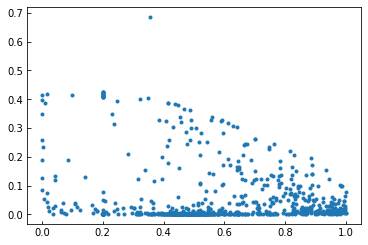

In [22]:
plt.plot(alls['b'].values.astype(float),alls['depth'].values.astype(float),'.')

In [29]:
Sample=alls.loc[(alls['flag']=='planet')&(alls['b'].values.astype(float)<0.8)&(alls['depth'].values.astype(float)<0.0025)&(alls['r_pl'].values.astype(float)<10)&(alls['snr'].values.astype(float)>10)]



In [39]:
ids=pd.DataFrame()
for allid in Sample.index.values:
    if allid[0]=='E':
        aid=allid[4:]
        mission='k2'
    elif allid[0]=='T':
        aid=allid[3:]
        mission='tess'
    ser=starpars.GetExoFop(aid,mission)
    print(type(ser[0]),ser[0])
    ser[0]['id']=aid
    ser[0].name=allid
    ids=ids.append(ser[0])

DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=279741379 HTTP/1.1" 200 21925
<class 'pandas.core.series.Series'> mission            tess
ra          03:27:00.05
dec         -63:30:00.6
long_gal         279.23
lat_gal        -45.8227
               ...     
jmagep             0.02
hmagem            0.031
hmagep            0.031
kmagem            0.024
kmagep            0.024
Name: 279741379, Length: 82, dtype: object
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=441462736 HTTP/1.1" 200 44705
<class 'pandas.core.series.Series'> mission             tess
ra           23:32:07.96
dec         -21:48:04.32
long_gal         45.0725
lat_gal    

DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=50898809 HTTP/1.1" 200 4104
<class 'pandas.core.series.Series'> mission             tess
ra           05:33:37.96
dec         -00:15:43.09
long_gal         204.025
lat_gal         -17.3647
                ...     
w3magep            0.026
w4magem            0.148
w4magep            0.148
em                      
ep                      
Name: 50898809, Length: 94, dtype: object
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=71512186 HTTP/1.1" 200 13371
<class 'pandas.core.series.Series'> mission             tess
ra           06:00:40.79
dec         -08:28:06.03
long_gal          214.83
lat_gal         -15.1008
                ...     
w2magep             0.02
w3magem             0.02
w3magep    

DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=62483237 HTTP/1.1" 200 72448
<class 'pandas.core.series.Series'> mission             tess
ra           22:25:36.58
dec         -34:54:34.97
long_gal         9.76016
lat_gal         -57.9908
                ...     
w2magep            0.021
w3magem            0.018
w3magep            0.018
w4magem            0.113
w4magep            0.113
Name: 62483237, Length: 99, dtype: object
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=192790476 HTTP/1.1" 200 6743
<class 'pandas.core.series.Series'> mission             tess
ra            05:28:34.4
dec         -39:22:22.96
long_gal         244.247
lat_gal         -32.1837
                ...     
w3magep            0.018
w4magem            0.099
w4magep   

DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=280865159 HTTP/1.1" 200 11641
<class 'pandas.core.series.Series'> mission             tess
ra           06:43:11.66
dec         -78:16:51.94
long_gal         289.772
lat_gal         -26.9352
                ...     
w2magep             0.02
w3magem            0.024
w3magep            0.024
w4magem            0.336
w4magep            0.336
Name: 280865159, Length: 73, dtype: object
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=297020814 HTTP/1.1" 200 4107
<class 'pandas.core.series.Series'> mission             tess
ra           11:37:42.48
dec         -14:40:02.25
long_gal          277.52
lat_gal          44.5359
                ...     
w3magep            0.017
w4magem            0.202
w4magep 

DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /k2/download_target.php?id=211351543 HTTP/1.1" 200 3955
<class 'pandas.core.series.Series'> mission                k2
ra            08:37:20.04
dec           10:50:33.89
GalLong           215.031
GalLat            28.3883
                 ...     
disep               204.2
massem              0.293
massep              0.293
rho_gcm3em         0.3478
rho_gcm3ep         0.3478
Name: 211351543, Length: 90, dtype: object
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /k2/download_target.php?id=204533587 HTTP/1.1" 200 5682
<class 'pandas.core.series.Series'> mission                 k2
ra             15:55:06.37
dec           -21:56:55.77
GalLong            349.676
GalLat             23.8191
                  ...     
disep                374.8
massem       

<class 'pandas.core.series.Series'> mission                 k2
ra             13:28:19.09
dec           -07:15:50.93
GalLong            318.804
GalLat             54.4671
                  ...     
disep                134.3
massem               0.124
massep               0.124
rho_gcm3em            0.38
rho_gcm3ep            0.38
Name: 212739532, Length: 90, dtype: object
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /k2/download_target.php?id=246297717 HTTP/1.1" 200 3588
<class 'pandas.core.series.Series'> mission                 k2
ra             23:25:02.41
dec           -03:06:40.84
GalLong            78.5075
GalLat            -58.3231
                  ...     
disep                6.944
massem               0.109
massep               0.109
rho_gcm3em          0.1144
rho_gcm3ep          0.1144
Name: 246297717, Length: 74, dtype: obj

DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /k2/download_target.php?id=211518462 HTTP/1.1" 200 3978
<class 'pandas.core.series.Series'> mission                k2
ra            08:28:43.01
dec           13:23:57.81
GalLong           211.409
GalLat            27.5301
                 ...     
disep               193.2
massem               0.09
massep               0.09
rho_gcm3em         0.3156
rho_gcm3ep         0.3156
Name: 211518462, Length: 90, dtype: object
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /k2/download_target.php?id=212170256 HTTP/1.1" 200 4075
<class 'pandas.core.series.Series'> mission                k2
ra            08:32:55.52
dec           23:29:37.25
GalLong           200.967
GalLat            32.1081
                 ...     
disep               64.25
massem              

DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=404518509 HTTP/1.1" 200 6800
<class 'pandas.core.series.Series'> mission             tess
ra           03:26:33.68
dec         -43:36:49.19
long_gal         251.108
lat_gal         -54.7699
                ...     
w3magep            0.018
w4magem            0.097
w4magep            0.097
em                      
ep                      
Name: 404518509, Length: 94, dtype: object
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=422914082 HTTP/1.1" 200 6931
<class 'pandas.core.series.Series'> mission            tess
ra           02:33:14.5
dec         01:41:27.35
long_gal        167.384
lat_gal        -52.1691
               ...     
hmagep            0.084
kmagem            0.034
kmagep           

DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=148782377 HTTP/1.1" 200 14610
<class 'pandas.core.series.Series'> mission            tess
ra          14:36:08.89
dec         42:22:42.45
long_gal        75.3323
lat_gal         63.8122
               ...     
w2magep            0.02
w3magem           0.018
w3magep           0.018
w4magem             0.1
w4magep             0.1
Name: 148782377, Length: 92, dtype: object
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /tess/download_target.php?id=219857012 HTTP/1.1" 200 14881
<class 'pandas.core.series.Series'> mission            tess
ra          17:09:18.93
dec         71:52:36.02
long_gal        103.249
lat_gal         33.5512
               ...     
w2magep            0.02
w3magem           0.016
w3magep           0.016
w4

In [40]:
Sample_merge=pd.merge(Sample,ids,left_index=True,right_index=True)

In [50]:
all_samples=Sample_merge.loc[(Sample_merge.lat_ecl<60)+pd.isnull(Sample_merge.lat_ecl)]

In [53]:
Sample_merge.to_csv("all_cheops_monos.csv")

In [ ]:
problems=[]
for targ in Sample_merge.loc[(Sample_merge.lat_ecl<60)+pd.isnull(Sample_merge.lat_ecl)].iterrows():
    file_loc=tools.MonoData_savepath+'/'+tools.id_dic[targ[1]['mission']]+str(int(targ[1]['id'])).zfill(11)
    radec=SkyCoord(targ[1]['ra'],targ[1]['dec'],unit=(u.hourangle,u.deg))
    try:
        outs=search.MonoVetting(int(targ[1]['id']), targ[1]['mission'],
                                coords=str(radec.ra.deg)+","+str(radec.dec.deg),
                                useL2=False, PL_ror_thresh=0.2,
                                variable_llk_thresh=5,file_loc=file_loc,
                                plot=True,overwrite=None,do_fit=False)
    except:
        problems+=[targ[0]]
print(problems)

loading from  /Volumes/LUVOIR/MonoToolsData/EPIC00201132684/EPIC00201132684_starpars.csv
[0.945355, 0.0631975, 0.0399281] [5549.0, -89.0, 89.0] [4.46185, 0.06478, 0.0959728] [1.1032496736276884, 0.197081, 0.303752] 0.9
{'00': {'tcen': 630.8965495217236, 'depth': 0.001317419079283114, 'period': 309.29360038121706, 'orbit_flag': 'mono', 'flag': 'planet'}, '01': {'tcen': 640.7913116806961, 'depth': 0.0007401303752732386, 'period': 20.129945915504436, 'orbit_flag': 'FP - confusion with 01', 'flag': 'FP - confusion'}, '02': {'tcen': 604.8274596738114, 'depth': 0.0008337504448649367, 'period': 20.759524136993054, 'orbit_flag': 'mono', 'flag': 'planet'}, '03': {'tcen': 610.5999418527784, 'depth': 0.0008414508635479847, 'period': 40.25184638959854, 'orbit_flag': 'duo', 'flag': 'planet'}, '04': {'tcen': 630.3219269229091, 'depth': 0.0011763803691841519, 'period': 19.850562530976088, 'orbit_flag': 'mono', 'flag': 'variability'}, '05': {'tcen': 650.851788242377, 'depth': 0.000806440493011516, 'pe

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2163.652711664745 -> 2244.371319456726


3.514245125210308 0.19323757249957546 fails with transits at  [ 3.62949789 21.28789074 38.9462836  56.60467645] with durations 0.19323757249957546 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 49 durations
Searching 2511 data points, 5074 periods from 1.1 to 23.02 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1517.270778726287 -> 1521.635591562391


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 49 durations
Searching 2511 data points, 5074 periods from 1.1 to 23.02 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Optimization terminated successfully.
logp: 2012.543597667293 -> 2019.946497666395


5 detection at  12.566527192143125  with  4  transits does not meet SNR  6.917136482313486 or FAP 0.000640256
transit mask: <class 'numpy.ndarray'> 2531 1 <class 'numpy.ndarray'> 2531 True
WARNING [matplotlib.axes._axes._parse_scatter_color_args()]: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 2531 1 <class 'numpy.ndarray'> 2531 True


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Optimization terminated successfully.
logp: 1511.599631708918 -> 1521.0618017693287


03 Checks complete.  SNR: 13.05187  SNR_r: 8.471170  variability: -25.0965  centroid: None | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Mono-mono compare 00 609.7283476040596 ['621.5808970403066'] [71.79856197]
Mono-mono compare 01 621.5808970403066 ['609.7283476040596'] [71.79856197]
{'00': {'tcen': 609.7283476040596, 'depth': 0.00043593374799783766, 'dur': 0.24758558463722122, 'period': 39.80934937504066, 'orbit_flag': 'mono', 'flag': 'planet'}, '01': {'tcen': 621.5808970403066, 'depth': 0.0008350979482922055, 'dur': 0.0825756083075014, 'period': 2.9217410741383016, 'orbit_flag': 'mono', 'flag': 'planet'}, '02': {'tcen': 645.0323275996828, 'depth': 0.0003238149674336744, 'dur': 0.2542985379657374, 'perio

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Optimization terminated successfully.
logp: 8385.553931486658 -> 8391.271971160473


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3718 data points, 6044 periods from 1.1 to 26.691 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 7083.164127154626 -> 7125.074256668449


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3718 data points, 6044 periods from 1.1 to 26.691 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 7245.83713572137 -> 7246.214598249665


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3718 data points, 6044 periods from 1.1 to 26.691 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 6645.266539302794 -> 6649.791123547813


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3718 data points, 6044 periods from 1.1 to 26.691 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 7814.6793191155675 -> 7814.72387599495


transit mask: <class 'numpy.ndarray'> 4022 0 <class 'numpy.ndarray'> 4022 True
WARNING [matplotlib.axes._axes._parse_scatter_color_args()]: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 4022 0 <class 'numpy.ndarray'> 4022 True


optimizing logp for variables: [tcen, log_per, log_ror, mean]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ 1.18625470e+00, -1.33236822e+00, -1.00000000e+00,  1.63763381e+04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 20
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([0.        , 2.92147582,       -inf, 0.        ])


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan


00 Checks complete.  SNR: 0.304654  SNR_r: 0.625186  variability: 2.451932  centroid: None | flag: lowSNR
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': -182.61468648642278, 'depth': 7.159644771381756e-06, 'dur': 0.25392614982790956, 'period': 18.56867126336049, 'orbit_flag': 'periodic', 'flag': 'lowSNR'}}
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': -182.61468648642278, 'depth': 7.159644771381756e-06, 'period': 18.56867126336

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1152.542978020529 -> 1153.3379283338463


7.188850442066839 0.1715895464225722 fails with transits at  [ 7.15837239 47.69722133] with durations 0.1715895464225722 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 50 durations
Searching 2228 data points, 5738 periods from 1.1 to 25.54 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ 1.75512934e-01,  2.84867013e-01, -1.00000000e+00, -1.72211897e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 36
   status: 2
  success: False
        x: array([0.       , 2.9198629,      -inf, 0.       ])


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 50 durations
Searching 2228 data points, 5738 periods from 1.1 to 25.54 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 4996.863399905815 -> 4997.256419613967


5 detection at  5.203369715169604  with  2  transits does not meet SNR  3.400984312189177 or FAP 0.003201281
transit mask: <class 'numpy.ndarray'> 3753 0 <class 'numpy.ndarray'> 3753 True
WARNING [matplotlib.axes._axes._parse_scatter_color_args()]: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 3753 0 <class 'numpy.ndarray'> 3753 True


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1637.2994095371885 -> 1651.182576463809


03 Checks complete.  SNR: 6.916390  SNR_r: 7.732122  variability: -5.74828  centroid: None | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': -223.797037421799, 'depth': 0.0005419317923589359, 'dur': 0.18207525409631767, 'period': 98.36502464162183, 'orbit_flag': 'mono', 'flag': 'lowSNR'}, '01': {'tcen': -227.39886790158658, 'depth': 0.00019885155828770957, 'dur': 0.3100186967619797, 'period': 479.2682367350989, 'orbit_flag': 'mono', 'flag': 'step'}, '02': {'tcen': -222.89003737399574, 'depth': 0.00016936580584885657, 'dur': 0.19728337904128976, 'period': 133.36379366527348, 'orbit_flag': 'mono', 'flag': 'lowSNR'}, '03': {'tcen': -260.00353528992537, 'depth': 0.0002602601123915685, 'dur': 0.13844

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 5546.091118818818 -> 5546.485742365596


2.8416190636337206 0.08622091862086455 fails with transits at  [ 7.25455234 11.66762195] with durations 0.08622091862086455 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 50 durations
Searching 2238 data points, 5740 periods from 1.1 to 25.547 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Optimization terminated successfully.
logp: 1536.1235216857797 -> 1537.5798332863403


11.615309547396679 0.18597412852655051 fails with transits at  [11.59230966 53.78675041] with durations 0.18597412852655051 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 50 durations
Searching 2238 data points, 5740 periods from 1.1 to 25.547 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2429.751434463289 -> 2437.907069072437


4 detection at  7.356491236826777  with  2  transits does not meet SNR  6.8820020561181385 or FAP 0.021768707
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': -259.8192426985259, 'depth': 0.019965211743756362, 'dur': 0.10992197869201634, 'period': 4.51471605807923, 'orbit_flag': 'mono', 'flag': 'lowSNR'}, '01': {'tcen': -264.22972032377567, 'depth': 0.013534104483308145, 'dur': 0.05756922897042692, 'period': 0.765818684386718, 'orbit_flag': 'mono', 'flag': 'lowSNR'}}
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 916.377354232409 -> 923.077198844489


9 detection at  91.18532888452387  with  0  transits does not meet SNR  nan or FAP 8.0032e-05
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 1018.2748423410849, 'depth': 0.015421801438767176, 'dur': 0.08236760817766103, 'period': 1.6308629325385369, 'orbit_flag': 'mono', 'flag': 'lowSNR'}, '01': {'tcen': 1024.4110478430916, 'depth': 0.022343456973183563, 'dur': 0.0743757841067878, 'period': 1.6107019969328291, 'orbit_flag': 'mono', 'flag': 'lowSNR'}, '02': {'tcen': 1010.6818346301058, 'depth': 0.012565812181252585, 'dur': 0.06754476785012725, 'period': 1.6133557901016091, 'orbit_flag': 'mono', 'flag': 'lowSNR'},

optimizing logp for variables: [tcen, log_per, log_ror, mean]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ 6.40443674e-02,  5.17410646e-02, -1.00000000e+00, -5.93220897e+04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 18
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([0.        , 3.69143239,       -inf, 0.        ])


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan


11.563905962688558 0.2543259752297253 fails with transits at  [252.1773926] with durations 0.2543259752297253 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 57 durations
Searching 3277 data points, 21664 periods from 1.1 to 47.443 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1178.9459426494304 -> 1208.2269977810543


4 detection at  40.14176332402438  with  1  transits does not meet SNR  4.069827329257171 or FAP 8.0032e-05
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 1275.3212964927384, 'depth': 0.0012126034246008966, 'dur': 0.3094060849138225, 'period': 20.488320259873923, 'orbit_flag': 'mono', 'flag': 'lowSNR'}, '01': {'tcen': 1264.7736718592434, 'depth': 0.0004747619622966453, 'dur': 0.5479944052966562, 'period': 139.73066491860732, 'orbit_flag': 'mono', 'flag': 'lowSNR'}, '02': {'tcen': 1255.3441106065811, 'depth': 0.0003995469874907842, 'dur': 0.3374879049198269, 'period': 36.88967945510418, 'orbit_flag': 'mono', 'fla

02 - Checks complete.  SNR: 0.243548  SNR_r: 0.279651  variability: 2.314160  centroid: -0.21855 | flag: lowSNR
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 7246 1 <class 'numpy.ndarray'> 7246 True
           bic: -911.0253763104345
 final_simplex: (array([[-2.03833481e+01,  1.39371212e+01,  4.80204940e-03,
         1.26259690e-02, -6.24063593e-03, -4.12926053e-02,
         1.87760341e-02,  4.44328526e-03],
       [-2.03833242e+01,  1.39371493e+01,  4.80203810e-03,
         1.26259331e-02, -6.24062853e-03, -4.12925939e-02,
         1.87760562e-02,  4.44328405e-03],
       [-2.03833139e+01,  1.39370907e+01,  4.80207028e-03,
         1.26259721e-02, -6.24063989e-03, -4.12924650e-02,
  

07 - Checks complete.  SNR: 1.988364  SNR_r: 0.665051  variability: 1.082169  centroid: -1.42368 | flag: lowSNR
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 7246 1 <class 'numpy.ndarray'> 7246 True
08 step. LogLik= 11.454779968447383
08 - Checks complete.  SNR: 10.48914  SNR_r: 6.921078  variability: 7.625565  centroid: None | flag: step
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Using TLS on ID=211351543 to search f

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1127.233652504607 -> 1130.3148466267617


1.2789330528332248 0.30599142830507964 fails with transits at  [1.27547061e+00 1.36514918e+03] with durations 0.30599142830507964 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 65 durations
Searching 6956 data points, 123165 periods from 1.1 to 97.944 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([-3.99239681e-01, -1.46328436e-01, -1.00000000e+00, -4.70018280e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 17
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([-8.88178420e-16,  4.30569797e+00,            -inf,  0.00000000e+00])


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan


10 detection at  74.12093160568847  with  2  transits does not meet SNR  5.5100481194565 or FAP 8.0032e-05
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Mono-mono compare 04 206.7775934321506 ['1258.9948199705393' '204.194021192925'] [13.23104905  4.68902581]
Mono-mono compare 05 1258.9948199705393 ['206.7775934321506' '204.194021192925'] [5388.63884964 1914.01939864]
Mono-mono compare 08 204.194021192925 ['206.7775934321506' '1258.9948199705393'] [4.68902581 4.69960694]
{'00': {'tcen': 1499.6635619636422, 'depth': 0.00025324153853502535, 'dur': 0.4044829491571979, 'period': 187.21960938479648, 'orbit_flag': 'mono', 'flag': 'l

211518462 - Searching 38536 positions with 5 durations: 0.156,0.291,0.41,0.524,0.632
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 5667 1 <class 'numpy.ndarray'> 5667 True
00 - Checks complete.  SNR: 10.12421  SNR_r: 9.868719  variability: -24.9410  centroid: None | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 5667 1 <class 'numpy.ndarray'> 5667 True
01 - Checks complet

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1050.6507934688213 -> 1053.0759066036644


0.6093043740485604 0.2898727217491008 fails with transits at  [6.41743979e-01 1.11939977e+03] with durations 0.2898727217491008 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 63 durations
Searching 5643 data points, 102023 periods from 1.1 to 81.188 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1392.0443177847922 -> 1392.458089905717


5 detection at  45.05921612694043  with  2  transits does not meet SNR  2.5975696706076157 or FAP 8.0032e-05
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Mono-mono compare 00 186.13277925485352 ['185.39892988219984'] [4.15558581]
Mono-mono compare 01 185.39892988219984 ['186.13277925485352'] [4.15558581]
{'00': {'tcen': 186.13277925485352, 'depth': 0.0003639272125339448, 'dur': 0.13970809303417392, 'period': 15.379710169518857, 'orbit_flag': 'mono', 'flag': 'planet'}, '01': {'tcen': 185.39892988219984, 'depth': 0.00034795436515157514, 'dur': 0.2134788734221595, 'period': 52.776828243434885, 'orbit_flag': 'mono', 'flag': 'plan

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1988.94771045984 -> 1990.9451504961562


1.1093085612687492 0.14627393303355846 fails with transits at  [20.15324751 58.14909583 77.14701998] with durations 0.14627393303355846 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3734 data points, 5996 periods from 1.1 to 26.512 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Optimization terminated successfully.
logp: 2932.078233237541 -> 2933.2534951218954


2 detection at  11.718188959193533  with  3  transits does not meet SNR  5.30464777696946 or FAP 0.006002401
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 1172.627574993636, 'depth': 0.001160112426166569, 'dur': 0.22426268138326508, 'period': 84.41876623675564, 'orbit_flag': 'mono', 'flag': 'planet'}}
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.


optimizing logp for variables: [mean, w0, power, logs2]


message: Optimization terminated successfully.
logp: 2.060886492870206 -> 2.693499178016109
Multiprocess sampling (4 chains in 4 jobs)


INFO  [pymc3.sample()]: Multiprocess sampling (4 chains in 4 jobs)


NUTS: [power, w0, logs2, mean]


INFO  [pymc3._print_step_hierarchy()]: NUTS: [power, w0, logs2, mean]


Sampling 4 chains, 0 divergences: 100%|██████████| 5976/5976 [00:03<00:00, 1541.06draws/s]


Forming Pymc3 model with: monos: ['00'] multis: [] duos: []
[77.22426239]
-6.907755278982137 -> -1.3862943611198906 -3.4492767019193167
LDs [[0.21571611 0.37509946]
 [0.71555795 0.06026187]
 [0.45034883 0.24299485]
 ...
 [0.59639794 0.15541812]
 [0.68471816 0.07479683]
 [0.25616771 0.32592385]]
[-5.9281116] 3723 / 3738
[False False False ... False False False] [False False False ... False False False] [False False False ... False False False]
#Marginalising over  1  period gaps for  00
{'logrho_S': array(0.93273591), 'Rs': array([0.694242]), 'mono_uniform_index_00_logodds__': array([1.31631238]), 'mono_t0s_00_interval__': array(0.), 'mono_logrors_00_interval__': array(0.5166761), 'mono_bs_00_impact__': array(-0.20694509), 'mono_eccs_00_interval__': array(-2.94462847), 'mono_omegas_00_angle__': array([0., 1.]), 'u_star_kep_interval__': array([ 0.28307525, -1.52654334]), 'mean': array(0.), 'logs2': array([-4.92811155]), 'w0_interval__': array(-1.90614294), 'power_interval__': array(-5.60

optimizing logp for variables: [power, w0, logs2, mean, u_star_kep, mono_omegas_00, mono_eccs_00, mono_bs_00, mono_logrors_00, mono_t0s_00, mono_uniform_index_00, Rs, logrho_S]


message: Desired error not necessarily achieved due to precision loss.
logp: 5737.556597503193 -> 25301.478061896803


before logrho_S                           0.19
Rs                                 0.55
mono_uniform_index_00_logodds__   -1.79
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.45
mono_bs_00_impact__               -1.40
mono_eccs_00_interval__           -1.90
mono_omegas_00_angle__            -0.50
u_star_kep_interval__             -2.05
mean                               5.20
logs2                             -1.61
w0_interval__                     -0.89
power_interval__                  -0.93
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 5737.556597503193 -> 5738.0249521596
optimizing logp for variables: [mono_uniform_index_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 5738.0249521596 -> 5738.0249521596
optimizing logp for variables: [mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00, logrho_S]


message: Optimization terminated successfully.
logp: 5738.0249521596 -> 5759.185700054844
optimizing logp for variables: [mean, w0, power, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: 5759.185700054844 -> 25293.806203278757
optimizing logp for variables: [mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 25293.806203278757 -> 25300.528428655784
optimizing logp for variables: [u_star_kep, logrho_S, Rs, logs2, mean, w0, power, mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00]


message: Desired error not necessarily achieved due to precision loss.
logp: 25300.528428655784 -> 25300.528464220737


after logrho_S                           0.19
Rs                                 0.55
mono_uniform_index_00_logodds__   -1.79
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.45
mono_bs_00_impact__               -1.40
mono_eccs_00_interval__           -1.90
mono_omegas_00_angle__            -0.50
u_star_kep_interval__             -2.05
mean                               5.20
logs2                             -1.61
w0_interval__                     -0.89
power_interval__                  -0.93
Name: Log-probability of test_point, dtype: float64
Gathering plots, overwrite: False
[1.] [ 0 24] 32 range(0, 1)
initialising transit
Initalising Transit models for plotting with n_samp= 1
Initalising GP models for plotting with n_samp= 1
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.t

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2019.9246185319676 -> 2020.7114673290416


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 69 durations
Searching 9577 data points, 107044 periods from 1.1 to 134.332 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1536.8109466531585 -> 1540.5790857282407


6 detection at  71.72170431422195  with  2  transits does not meet SNR  3.476624995086524 or FAP 8.0032e-05
transit mask: <class 'numpy.ndarray'> 9822 1 <class 'numpy.ndarray'> 9822 True
WARNING [matplotlib.axes._axes._parse_scatter_color_args()]: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 9822 1 <class 'numpy.ndarray'> 9822 True


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -844.0340038401048 -> -762.4542630100158


05 Checks complete.  SNR: 16.00397  SNR_r: 13.70896  variability: -69.3676  centroid: None | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Mono-mono compare 00 1165.6551478071035 ['1259.325021010426' '181.61261189149604' '1262.6144989588136'] [377.49638422 443.6450353  529.76536047]
Mono-mono compare 02 1259.325021010426 ['1165.6551478071035' '181.61261189149604' '1262.6144989588136'] [13.25683476 13.38556641 15.55860151]
Mono-mono compare 03 181.61261189149604 ['1165.6551478071035' '1259.325021010426' '1262.6144989588136'] [4660.68299932 4004.27269112 5641.55519754]
Mono-mono compare 04 1262.6144989588136 ['1165.6551478071035' '1259.325021010426' '181.61261189149604'] [18.60418309 15.55860151 18.85870858]
{'

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1149.1159788981695 -> 1155.205088157197


1 detection at  80.22664346860441  with  2  transits does not meet SNR  5.400112888555795 or FAP 8.0032e-05
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 151.72150830972583, 'depth': 0.00032328820647155505, 'dur': 0.21941293840680257, 'period': 11.383530499134405, 'orbit_flag': 'mono', 'flag': 'lowSNR'}}
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType fon

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 878.3353797208594 -> 879.3249711356741


5.843767835712829 0.34780351756037853 fails with transits at  [5.83478184] with durations 0.34780351756037853 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 65 durations
Searching 6562 data points, 91833 periods from 1.1 to 95.218 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Optimization terminated successfully.
logp: 1073.8108069261768 -> 1076.365144984053


8.49993758369231 0.258347507615818 fails with transits at  [   8.50370302 1013.83397106] with durations 0.258347507615818 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 65 durations
Searching 6562 data points, 91833 periods from 1.1 to 95.218 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2153.379382065976 -> 2154.448967008702


7 detection at  50.26450752471418  with  1  transits does not meet SNR  5.258341959543826 or FAP 8.0032e-05
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Mono-mono compare 00 226.0179926653828 ['1231.3134301410084' '259.420223430431'] [69.48028389 70.5224971 ]
Mono-mono compare 01 1231.3134301410084 ['226.0179926653828' '259.420223430431'] [2021.64389512 2088.55386251]
Mono-mono compare 04 259.420223430431 ['226.0179926653828' '1231.3134301410084'] [70.5224971  71.77985976]
{'00': {'tcen': 226.0179926653828, 'depth': 0.000764360635989027, 'dur': 0.48904072366215534, 'period': 277.16572165023166, 'orbit_flag': 'mono', 'flag': '

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2053.5572155898294 -> 2055.997729319355


2.7693773073467374 0.16686518844342735 fails with transits at  [ 2.77304972 44.21491897 64.9358536 ] with durations 0.16686518844342735 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3667 data points, 5939 periods from 1.1 to 26.296 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3940.3292979533826 -> 3940.462738353809


3 detection at  10.606326433595004  with  6  transits does not meet SNR  4.98676533981952 or FAP nan
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Mono-mono compare 00 261.6651075671276 ['220.24462589583885'] [357.83576075]
Mono-mono compare 01 220.24462589583885 ['261.6651075671276'] [357.83576075]
{'00': {'tcen': 261.6651075671276, 'depth': 0.0017921851674903247, 'dur': 0.11034766654895194, 'period': 5.302397796547019, 'orbit_flag': 'mono', 'flag': 'planet'}, '01': {'tcen': 220.24462589583885, 'depth': 0.00047430114883359063, 'dur': 0.12115787992893469, 'period': 7.096995680637349, 'orbit_flag': 'mono', 'flag': 'planet'}}
Mo

optimizing logp for variables: [mean, w0, power, logs2]


message: Optimization terminated successfully.
logp: 1.8257874807597583 -> 2.5937278552216028


Multiprocess sampling (4 chains in 4 jobs)


INFO  [pymc3.sample()]: Multiprocess sampling (4 chains in 4 jobs)


NUTS: [power, w0, logs2, mean]


INFO  [pymc3._print_step_hierarchy()]: NUTS: [power, w0, logs2, mean]


Sampling 4 chains, 0 divergences: 100%|██████████| 5976/5976 [00:04<00:00, 1466.02draws/s]


Forming Pymc3 model with: monos: ['00', '01'] multis: [] duos: []
[35.5104305  38.08348423]
-6.907755278982137 -> -1.3862943611198906 -3.2005097480828146
-6.907755278982137 -> -1.3862943611198906 -3.8713612548573404
LDs [[0.37960031 0.29993332]
 [0.5042672  0.20764053]
 [0.44681989 0.24524325]
 ...
 [0.47372245 0.2271659 ]
 [0.48000687 0.22423051]
 [0.46532607 0.23790693]]
[-2.5409856] 3653 / 3668
[False False False ... False False False] [False False False ... False False False] [False False False ... False False False]
#Marginalising over  2  period gaps for  00
#Marginalising over  3  period gaps for  01
{'name': '00', 'n_points': 6, 'durs': mono_tdurs_00
array([0.2204223 , 0.26410638]), 'pers': mono_periods_00
array([35.58185965, 61.20664427]), 'len': 2, 'range': array([0, 1]), 'lcs': Sum{axis=[2], acc_dtype=float64}.0
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]]), 'logpriors': Elemwise{add,no_inplace}.0
array([-1

optimizing logp for variables: [power, w0, logs2, mean, u_star_kep, mono_omegas_01, mono_eccs_01, mono_bs_01, mono_logrors_01, mono_t0s_01, mono_uniform_index_01, mono_omegas_00, mono_eccs_00, mono_bs_00, mono_logrors_00, mono_t0s_00, mono_uniform_index_00, Rs, logrho_S]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[ 2.70552960e-01,  2.84740907e-02, -1.36840354e-03,
        -1.33084602e-04,  2.39544447e-02,  9.94717063e-03,
         1.91813709e-04,  6.27471505e-03,  1.49404402e-05,
         2.06358670e-03, -1.58398526e-02,  1.25760090e-03,
         1.09330168e-04,  1.16441374e-03, -3.86750402e-04,
         5.17960696e-03,  6.33491409e-03,  3.87543482e-04,
         5.35873924e-02, -2.37556026e-01, -7.88375561e-03,
         2.00683450e-04,  4.45782331e-04,  2.73545137e-01,
         6.45030341e-02],
       [ 2.84740907e-02,  1.10853000e-02, -2.41762015e-03,
        -2.63310224e-05,  2.91327842e-03,  1.22653628e-03,
         8.40509476e-05, -5.91306325e-04,  5.23499790e-06,
         6.00611305e-04, -1.50727460e-03,  2.38470690e-04,
         4.19752173e-06,  1.10792199e-

message: Desired error not necessarily achieved due to precision loss.
logp: -579.3944360943113 -> nan


before logrho_S                            0.16
Rs                                  0.24
mono_uniform_index_00_logodds__    -5.12
mono_t0s_00_interval__             -0.42
mono_logrors_00_interval__         -1.51
mono_bs_00_impact__                -1.42
mono_eccs_00_interval__            -4.08
mono_omegas_00_angle__             -0.50
mono_uniform_index_01_logodds__   -14.66
mono_t0s_01_interval__             -0.42
mono_logrors_01_interval__         -1.40
mono_bs_01_impact__                -1.41
mono_eccs_01_interval__            -4.08
mono_omegas_01_angle__             -0.50
u_star_kep_interval__               0.71
mean                                5.30
logs2                              -1.61
w0_interval__                      -0.95
power_interval__                   -0.91
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mono_uniform_index_01, mono_bs_01, mono_logrors_01, mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: -579.3944360943113 -> -566.3841306764758
optimizing logp for variables: [mono_uniform_index_01, mono_logrors_01, mono_uniform_index_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: -566.3841306764758 -> -566.3841306764758
optimizing logp for variables: [mono_omegas_01, mono_eccs_01, mono_t0s_01, mono_bs_01, mono_logrors_01, mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00, logrho_S]


message: Optimization terminated successfully.
logp: -566.3841306764758 -> -525.4194136730274
optimizing logp for variables: [mean, w0, power, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: -525.4194136730274 -> 25789.69814827628
optimizing logp for variables: [mono_uniform_index_01, mono_bs_01, mono_logrors_01, mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 25789.69814827628 -> 25792.846985460175
optimizing logp for variables: [u_star_kep, logrho_S, Rs, logs2, mean, w0, power, mono_omegas_01, mono_eccs_01, mono_t0s_01, mono_bs_01, mono_logrors_01, mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 25792.846985460175 -> 25792.901040238994


after logrho_S                            0.16
Rs                                  0.24
mono_uniform_index_00_logodds__    -5.12
mono_t0s_00_interval__             -0.42
mono_logrors_00_interval__         -1.51
mono_bs_00_impact__                -1.42
mono_eccs_00_interval__            -4.08
mono_omegas_00_angle__             -0.50
mono_uniform_index_01_logodds__   -14.66
mono_t0s_01_interval__             -0.42
mono_logrors_01_interval__         -1.40
mono_bs_01_impact__                -1.41
mono_eccs_01_interval__            -4.08
mono_omegas_01_angle__             -0.50
u_star_kep_interval__               0.71
mean                                5.30
logs2                              -1.61
w0_interval__                      -0.95
power_interval__                   -0.91
Name: Log-probability of test_point, dtype: float64
Gathering plots, overwrite: False
[1.] [ 0 24] 32 range(0, 1)
initialising transit
Initalising Transit models for plotting with n_samp= 1
Initalising GP models for

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 566.2666003600409 -> 569.2114035542651


96.02645637459352 0.28527707315233103 fails with transits at  [963.06417302] with durations 0.28527707315233103 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 65 durations
Searching 6782 data points, 91939 periods from 1.1 to 96.337 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 38910.233944626336 -> 38913.969528159825


1 detection at  1.9570995380148468  with  2  transits does not meet SNR  4.155550292416011 or FAP 0.001120448
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
nothing detected
loading from  /Volumes/LUVOIR/MonoToolsData/EPIC00220315458/EPIC00220315458_starpars.csv
[1.00612, 0.044992, 0.0464653] [5525.82, 105.992, 102.065] [4.41954, 0.082087, 0.0707755] [0.969362556703829, 0.166332, 0.223826] 1.01
220315458 - Searching 29845 positions with 5 durations: 0.124,0.231,0.325,0.416,0.502
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.b

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1694.1486460724657 -> 1696.2169765049673


2.8098550302977747 0.1740155192601199 fails with transits at  [ 2.7770088  50.79599292 74.80548497] with durations 0.1740155192601199 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 50 durations
Searching 3432 data points, 5772 periods from 1.1 to 25.669 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3927.0962955625014 -> 3933.4548865210595


0.11976349383564872 0.208010087200462 fails with transits at  [ 0.17954098 18.47951334 36.77948571 55.07945808 73.37943045] with durations 0.208010087200462 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 50 durations
Searching 3432 data points, 5772 periods from 1.1 to 25.669 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 9195.641495690043 -> 9196.73837221036


3.104741689906788 0.17081522522521123 fails with transits at  [16.66172764 30.34427948 44.02683133 57.70938318 71.39193502] with durations 0.17081522522521123 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 50 durations
Searching 3432 data points, 5772 periods from 1.1 to 25.669 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3101.802346526952 -> 3102.978428440605


23.23730965970966 0.19830193679865218 fails with transits at  [23.26141381 47.00089683 70.74037984] with durations 0.19830193679865218 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 50 durations
Searching 3432 data points, 5772 periods from 1.1 to 25.669 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ 2.00179377e+00,  1.16369036e-01, -1.00000000e+00, -7.20542731e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 40
   status: 2
  success: False
        x: array([0.        , 0.66467905,       -inf, 0.        ])


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan


5 detection at  1.9438665421416816  with  0  transits does not meet SNR  3.7285621055348273 or FAP 0.052501
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 444.48809142313644, 'depth': 0.0008354521585364681, 'dur': 0.1468408854870997, 'period': 10.839880328555708, 'orbit_flag': 'mono', 'flag': 'planet'}}
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.

optimizing logp for variables: [mean, w0, power, logs2]


message: Optimization terminated successfully.
logp: 1.226337916063363 -> 2.1089359107131296


Multiprocess sampling (4 chains in 4 jobs)


INFO  [pymc3.sample()]: Multiprocess sampling (4 chains in 4 jobs)


NUTS: [power, w0, logs2, mean]


INFO  [pymc3._print_step_hierarchy()]: NUTS: [power, w0, logs2, mean]


Sampling 4 chains, 0 divergences: 100%|██████████| 5976/5976 [00:03<00:00, 1594.35draws/s]


Forming Pymc3 model with: monos: ['00'] multis: [] duos: []
[50.8295984]
-6.907755278982137 -> -1.3862943611198906 -3.5976303469728084
LDs [[0.49040776 0.2166334 ]
 [0.51498528 0.20032175]
 [0.52204056 0.19477164]
 ...
 [0.4937715  0.21472539]
 [0.51012542 0.20336336]
 [0.46027795 0.237168  ]]
[-5.4171033] 3424 / 3433
[False False False ... False False False] [False False False ... False False False] [False False False ... False False False]
#Marginalising over  1  period gaps for  00
{'logrho_S': array(-0.03111658), 'Rs': array([1.00612]), 'mono_uniform_index_00_logodds__': array([0.96278126]), 'mono_t0s_00_interval__': array(0.), 'mono_logrors_00_interval__': array(0.40338908), 'mono_bs_00_impact__': array(0.09794911), 'mono_eccs_00_interval__': array(-2.94462847), 'mono_omegas_00_angle__': array([0., 1.]), 'u_star_kep_interval__': array([ 0.0336548 , -1.36010684]), 'mean': array(0.), 'logs2': array([-4.41710329]), 'w0_interval__': array(-2.49264838), 'power_interval__': array(-5.460

optimizing logp for variables: [power, w0, logs2, mean, u_star_kep, mono_omegas_00, mono_eccs_00, mono_bs_00, mono_logrors_00, mono_t0s_00, mono_uniform_index_00, Rs, logrho_S]


message: Desired error not necessarily achieved due to precision loss.
logp: 4419.684491086766 -> 27388.21591330576


before logrho_S                           0.68
Rs                                 2.17
mono_uniform_index_00_logodds__   -1.61
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.43
mono_bs_00_impact__               -1.39
mono_eccs_00_interval__           -1.90
mono_omegas_00_angle__            -0.50
u_star_kep_interval__              0.95
mean                               4.50
logs2                             -1.61
w0_interval__                     -0.95
power_interval__                  -0.97
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 4419.684491086766 -> 4419.940168632799
optimizing logp for variables: [mono_uniform_index_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 4419.940168632799 -> 4419.940168632799
optimizing logp for variables: [mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00, logrho_S]


message: Desired error not necessarily achieved due to precision loss.
logp: 4419.940168632799 -> 4441.08517841922
optimizing logp for variables: [mean, w0, power, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: 4441.08517841922 -> 27305.202506870028
optimizing logp for variables: [mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 27305.20250687003 -> 27317.232221367874
optimizing logp for variables: [u_star_kep, logrho_S, Rs, logs2, mean, w0, power, mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 27317.232221367874 -> 27317.308531725736


after logrho_S                           0.68
Rs                                 2.17
mono_uniform_index_00_logodds__   -1.61
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.43
mono_bs_00_impact__               -1.39
mono_eccs_00_interval__           -1.90
mono_omegas_00_angle__            -0.50
u_star_kep_interval__              0.95
mean                               4.50
logs2                             -1.61
w0_interval__                     -0.95
power_interval__                  -0.97
Name: Log-probability of test_point, dtype: float64
Gathering plots, overwrite: False
[1.] [ 0 24] 32 range(0, 1)
initialising transit
Initalising Transit models for plotting with n_samp= 1
Initalising GP models for plotting with n_samp= 1
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.t

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3439.9261086579745 -> 3440.176371095788


5.682966307204681 0.18340908737097852 fails with transits at  [24.00933786 42.33666421] with durations 0.18340908737097852 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3714 data points, 5921 periods from 1.1 to 26.228 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3124.7032054723454 -> 3129.3007519967346


2 detection at  13.771744379979943  with  3  transits does not meet SNR  4.115852993040489 or FAP 0.002240896
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 416.0515230978475, 'depth': 0.0009580698053732105, 'dur': 0.34187861430758926, 'period': 68.53875377038385, 'orbit_flag': 'mono', 'flag': 'planet'}}
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font

optimizing logp for variables: [mean, w0, power, logs2]


message: Optimization terminated successfully.
logp: 3.420625370757116 -> 4.067449307960402


Multiprocess sampling (4 chains in 4 jobs)


INFO  [pymc3.sample()]: Multiprocess sampling (4 chains in 4 jobs)


NUTS: [power, w0, logs2, mean]


INFO  [pymc3._print_step_hierarchy()]: NUTS: [power, w0, logs2, mean]


Sampling 4 chains, 0 divergences: 100%|██████████| 5976/5976 [00:04<00:00, 1436.02draws/s]


Forming Pymc3 model with: monos: ['00'] multis: [] duos: []
[54.82706428]
-6.907755278982137 -> -1.3862943611198906 -3.532964067497969
LDs [[0.44417121 0.24699742]
 [0.43558827 0.25572907]
 [0.42447188 0.2605897 ]
 ...
 [0.43399554 0.25403674]
 [0.49836059 0.2098717 ]
 [0.40678312 0.27183867]]
[-2.4647257] 3696 / 3718
[False False False ... False False False] [False False False ... False False False] [False False False ... False False False]
#Marginalising over  1  period gaps for  00
{'logrho_S': array(-0.39586083), 'Rs': array([1.24]), 'mono_uniform_index_00_logodds__': array([0.20644562]), 'mono_t0s_00_interval__': array(0.), 'mono_logrors_00_interval__': array(0.45241579), 'mono_bs_00_impact__': array(-0.11795654), 'mono_eccs_00_interval__': array(-2.94462847), 'mono_omegas_00_angle__': array([0., 1.]), 'u_star_kep_interval__': array([-0.32190582, -1.0195853 ]), 'mean': array(0.), 'logs2': array([-1.46472573]), 'w0_interval__': array(-1.64684375), 'power_interval__': array(-5.11569

optimizing logp for variables: [power, w0, logs2, mean, u_star_kep, mono_omegas_00, mono_eccs_00, mono_bs_00, mono_logrors_00, mono_t0s_00, mono_uniform_index_00, Rs, logrho_S]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[ 9.99919797e-01,  2.80900251e-04,  5.18126408e-02,
        -8.91298721e-03, -4.45054653e-06, -1.31043993e-05,
        -9.43462347e-08, -5.30045170e-04, -1.87550674e-05,
        -1.90648382e-06,  5.56381629e-06, -1.25427392e-09,
         2.77137137e-06, -3.01472709e-08, -5.81598426e-07],
       [ 2.80900251e-04,  9.98801839e-01, -3.54085362e-02,
         3.52638849e-02,  3.42573743e-06,  9.37704067e-06,
         9.41131126e-07,  3.67437075e-04,  1.31088566e-05,
         4.70527143e-06,  6.81800816e-07, -2.69673120e-07,
        -7.02717788e-07, -2.63112091e-06,  7.69220022e-06],
       [ 5.18126408e-02, -3.54085362e-02,  2.31962516e-02,
        -1.74737095e-03, -4.94559154e-04, -3.85375889e-04,
        -1.29333976e-03,  2.32798256e-03, -8.78770619e-05,
   

message: Desired error not necessarily achieved due to precision loss.
logp: -695.990039098879 -> nan


before logrho_S                           0.13
Rs                                 0.34
mono_uniform_index_00_logodds__   -1.40
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.44
mono_bs_00_impact__               -1.39
mono_eccs_00_interval__           -1.90
mono_omegas_00_angle__            -0.50
u_star_kep_interval__              1.11
mean                               6.16
logs2                             -1.61
w0_interval__                     -0.74
power_interval__                  -1.09
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: -695.990039098879 -> -695.933263995883
optimizing logp for variables: [mono_uniform_index_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: -695.933263995883 -> -695.933263995883
optimizing logp for variables: [mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00, logrho_S]


message: Optimization terminated successfully.
logp: -695.933263995883 -> -674.7694271345252
optimizing logp for variables: [mean, w0, power, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: -674.7694271345252 -> 26648.98503206629
optimizing logp for variables: [mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 26648.98503206629 -> 26663.311525412944
optimizing logp for variables: [u_star_kep, logrho_S, Rs, logs2, mean, w0, power, mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00]


message: Desired error not necessarily achieved due to precision loss.
logp: 26663.311525412944 -> 26663.72909084605


after logrho_S                           0.13
Rs                                 0.34
mono_uniform_index_00_logodds__   -1.40
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.44
mono_bs_00_impact__               -1.39
mono_eccs_00_interval__           -1.90
mono_omegas_00_angle__            -0.50
u_star_kep_interval__              1.11
mean                               6.16
logs2                             -1.61
w0_interval__                     -0.74
power_interval__                  -1.09
Name: Log-probability of test_point, dtype: float64
Gathering plots, overwrite: False
[1.] [ 0 24] 32 range(0, 1)
initialising transit
Initalising Transit models for plotting with n_samp= 1
Initalising GP models for plotting with n_samp= 1
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.t

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2023.2977827706839 -> 2023.6749808994452


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 49 durations
Searching 2506 data points, 5074 periods from 1.1 to 23.02 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1872.883291546549 -> 1872.9453246624776


2 detection at  12.652228382306316  with  4  transits does not meet SNR  5.656231404178498 or FAP 0.002480992
transit mask: <class 'numpy.ndarray'> 2527 1 <class 'numpy.ndarray'> 2527 True
WARNING [matplotlib.axes._axes._parse_scatter_color_args()]: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 2527 1 <class 'numpy.ndarray'> 2527 True


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Optimization terminated successfully.
logp: 1687.76384745617 -> 1701.0956372055648


00 Checks complete.  SNR: 5.828992  SNR_r: 14.46391  variability: -26.0233  centroid: None | flag: lowSNR
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 584.3436639922787, 'depth': 0.000384691494910605, 'dur': 0.164840743114346, 'period': 19.525492710697986, 'orbit_flag': 'periodic', 'flag': 'lowSNR'}}
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 584.3436639922787, 'depth': 0.000384691494910605, 'period': 19.525492710697986, '

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -177.5992236011177 -> -113.02825199703169


0.2644776354707167 0.18152532617999664 fails with transits at  [ 0.14521934 46.28869391] with durations 0.18152532617999664 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3329 data points, 5917 periods from 1.1 to 26.214 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([-3.28794193e+00,  2.16100113e+00, -1.00000000e+00, -2.94956922e+06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 18
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([0.       , 3.2078328,      -inf, 0.       ])


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3329 data points, 5917 periods from 1.1 to 26.214 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 4487.099419342096 -> 4492.095273178179


7 detection at  8.839708532903815  with  2  transits does not meet SNR  5.827266940889415 or FAP 0.069147659
transit mask: <class 'numpy.ndarray'> 3354 1 <class 'numpy.ndarray'> 3354 True
WARNING [matplotlib.axes._axes._parse_scatter_color_args()]: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 3354 1 <class 'numpy.ndarray'> 3354 True


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 773.3839622702843 -> 944.6229131412


05 Checks complete.  SNR: 8.386818  SNR_r: 10.58148  variability: -121.879  centroid: None | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Mono-mono compare 00 760.3264666551373 ['784.8827884508786'] [60.07970427]
Mono-mono compare 01 784.8827884508786 ['760.3264666551373'] [60.07970427]
{'00': {'tcen': 760.3264666551373, 'depth': 0.0004310262513056916, 'dur': 0.26541446449438305, 'period': 29.812651266425487, 'orbit_flag': 'mono', 'flag': 'planet'}, '01': {'tcen': 784.8827884508786, 'depth': 0.0003681001536831754, 'dur': 0.5520436802419229, 'period': 213.84021996587902, 'orbit_flag': 'mono', 'flag': 'planet'}, '02': {'tcen': 743.866097173257, 'depth': 6.907749646399366e-05, 'dur': 0.377177342888949, 'period'

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1755.3239637353943 -> 1756.2540295199835


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3732 data points, 6008 periods from 1.1 to 26.555 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1991.222694631582 -> 1991.547375123692


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 51 durations
Searching 3732 data points, 6008 periods from 1.1 to 26.555 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2934.538824582207 -> 2934.854246404084


5 detection at  14.042319286883277  with  4  transits does not meet SNR  4.891654015206949 or FAP nan
transit mask: <class 'numpy.ndarray'> 3901 1 <class 'numpy.ndarray'> 3901 True
WARNING [matplotlib.axes._axes._parse_scatter_color_args()]: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
transit mask: <class 'numpy.ndarray'> 3901 1 <class 'numpy.ndarray'> 3901 True
WARNING [matplotlib.axes._axes._parse_scatter_color_args()]: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: 

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Optimization terminated successfully.
logp: 1320.348601214905 -> 1363.463828968725


03 Checks complete.  SNR: 7.009700  SNR_r: 22.68123  variability: -44.2415  centroid: None | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 3901 1 <class 'numpy.ndarray'> 3901 True


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2344.3366456991102 -> 2354.5739084966017


04 Checks complete.  SNR: 2.421825  SNR_r: 7.163082  variability: -8.32666  centroid: None | flag: lowSNR
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Mono-mono compare 00 927.5046424917813 ['977.8326990786103'] [249.93865897]
Mono-mono compare 02 977.8326990786103 ['927.5046424917813'] [249.93865897]
Multi-multi compare 03 25.15229653767933 04 17.58578126433903 0.3470175942712775
Multi-multi compare 04 17.58578126433903 03 25.15229653767933 0.3470175942712775
{'00': {'tcen': 927.5046424917813, 'depth': 0.0015823200384949474, 'dur': 0.23682702422147242, 'period': 97.70053818246755, 'orbit_flag': 'mono', 'flag': 'planet'}, '01': {'tcen': 912.8465535125977, 'depth': 0.00018645239932765393, 'dur': 0.3640045077923901, 'perio

optimizing logp for variables: [mean, w0, power, logs2]


message: Optimization terminated successfully.
logp: 1.2821097284654592 -> 1.9319040263208502


Multiprocess sampling (4 chains in 4 jobs)


INFO  [pymc3.sample()]: Multiprocess sampling (4 chains in 4 jobs)


NUTS: [power, w0, logs2, mean]


INFO  [pymc3._print_step_hierarchy()]: NUTS: [power, w0, logs2, mean]


Sampling 4 chains, 0 divergences: 100%|██████████| 5976/5976 [00:03<00:00, 1659.37draws/s]


Forming Pymc3 model with: monos: ['00', '02'] multis: [] duos: []
[58.00083467 72.14879384]
-6.907755278982137 -> -1.3862943611198906 -3.293833525780621
-6.907755278982137 -> -1.3862943611198906 -3.8329786255547487
LDs [[0.65032176 0.09898552]
 [0.64677476 0.10523153]
 [0.67086611 0.09638261]
 ...
 [0.63892573 0.10661151]
 [0.6120387  0.12519978]
 [0.61876711 0.12784276]]
[-5.320977] 3716 / 3742
[False False False ... False False False] [False False False ... False False False] [False False False ... False False False]
#Marginalising over  1  period gaps for  00
#Marginalising over  1  period gaps for  02
{'logrho_S': array(0.65118556), 'Rs': array([0.66]), 'mono_uniform_index_00_logodds__': array([-1.10426699]), 'mono_t0s_00_interval__': array(0.), 'mono_logrors_00_interval__': array(0.63897953), 'mono_bs_00_impact__': array(-0.11382931), 'mono_eccs_00_interval__': array(-2.94462847), 'mono_omegas_00_angle__': array([0., 1.]), 'mono_uniform_index_02_logodds__': array([-0.44416246]), '

optimizing logp for variables: [power, w0, logs2, mean, u_star_kep, mono_omegas_02, mono_eccs_02, mono_bs_02, mono_logrors_02, mono_t0s_02, mono_uniform_index_02, mono_omegas_00, mono_eccs_00, mono_bs_00, mono_logrors_00, mono_t0s_00, mono_uniform_index_00, Rs, logrho_S]


message: Desired error not necessarily achieved due to precision loss.
logp: 4596.048011683437 -> 25538.126937177447


before logrho_S                           0.41
Rs                                 2.30
mono_uniform_index_00_logodds__   -1.68
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.49
mono_bs_00_impact__               -1.39
mono_eccs_00_interval__           -4.08
mono_omegas_00_angle__            -0.50
mono_uniform_index_02_logodds__   -1.44
mono_t0s_02_interval__            -0.42
mono_logrors_02_interval__        -1.40
mono_bs_02_impact__               -1.39
mono_eccs_02_interval__           -4.08
mono_omegas_02_angle__            -0.50
u_star_kep_interval__              0.39
mean                               4.48
logs2                             -1.61
w0_interval__                     -0.84
power_interval__                  -0.92
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mono_uniform_index_02, mono_bs_02, mono_logrors_02, mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 4596.048011683437 -> 4596.495013298362
optimizing logp for variables: [mono_uniform_index_02, mono_logrors_02, mono_uniform_index_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 4596.495013298362 -> 4596.495013298362
optimizing logp for variables: [mono_omegas_02, mono_eccs_02, mono_t0s_02, mono_bs_02, mono_logrors_02, mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00, logrho_S]


message: Optimization terminated successfully.
logp: 4596.495013298362 -> 4637.460504979964
optimizing logp for variables: [mean, w0, power, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: 4637.460504979964 -> 25509.91843109314
optimizing logp for variables: [mono_uniform_index_02, mono_bs_02, mono_logrors_02, mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Desired error not necessarily achieved due to precision loss.
logp: 25509.91843109314 -> 25534.08215941788
optimizing logp for variables: [u_star_kep, logrho_S, Rs, logs2, mean, w0, power, mono_omegas_02, mono_eccs_02, mono_t0s_02, mono_bs_02, mono_logrors_02, mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00]


message: Desired error not necessarily achieved due to precision loss.
logp: 25534.08215941788 -> 25538.123155896938


after logrho_S                           0.41
Rs                                 2.30
mono_uniform_index_00_logodds__   -1.68
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.49
mono_bs_00_impact__               -1.39
mono_eccs_00_interval__           -4.08
mono_omegas_00_angle__            -0.50
mono_uniform_index_02_logodds__   -1.44
mono_t0s_02_interval__            -0.42
mono_logrors_02_interval__        -1.40
mono_bs_02_impact__               -1.39
mono_eccs_02_interval__           -4.08
mono_omegas_02_angle__            -0.50
u_star_kep_interval__              0.39
mean                               4.48
logs2                             -1.61
w0_interval__                     -0.84
power_interval__                  -0.92
Name: Log-probability of test_point, dtype: float64
Gathering plots, overwrite: False
[1.] [ 0 24] 32 range(0, 1)
initialising transit
Initalising Transit models for plotting with n_samp= 1
Initalising GP models for plotting with n_sa

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Optimization terminated successfully.
logp: 8463.575884773889 -> 8464.776433950465


1 detection at  5.908012617398504  with  2  transits does not meet SNR  6.513788839678485 or FAP 0.03857543
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 1042.4013620861583, 'depth': 0.0003654991190479295, 'dur': 0.35988138862731467, 'period': 84.14896783493566, 'orbit_flag': 'mono', 'flag': 'planet'}}
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.

optimizing logp for variables: [mean, w0, power, logs2]


message: Optimization terminated successfully.
logp: 2.6701474927199196 -> 3.0884700201404076


Multiprocess sampling (4 chains in 4 jobs)


INFO  [pymc3.sample()]: Multiprocess sampling (4 chains in 4 jobs)


NUTS: [power, w0, logs2, mean]


INFO  [pymc3._print_step_hierarchy()]: NUTS: [power, w0, logs2, mean]


Sampling 4 chains, 0 divergences: 100%|██████████| 5976/5976 [00:03<00:00, 1534.82draws/s]


Forming Pymc3 model with: monos: ['00'] multis: [] duos: []
[53.05925353]
-6.907755278982137 -> -1.3862943611198906 -4.017473600264966
LDs [[0.45634859 0.24044599]
 [0.39416791 0.28259425]
 [0.42524177 0.2615699 ]
 ...
 [0.45257418 0.24251881]
 [0.38923007 0.28625737]
 [0.4329083  0.25663591]]
[-5.812779] 4115 / 4138
[False False False ... False False False] [False False False ... False False False] [False False False ... False False False]
#Marginalising over  1  period gaps for  00
{'logrho_S': array(-0.52957135), 'Rs': array([1.23813]), 'mono_uniform_index_00_logodds__': array([-0.88401467]), 'mono_t0s_00_interval__': array(0.), 'mono_logrors_00_interval__': array(0.09392184), 'mono_bs_00_impact__': array(-0.19820854), 'mono_eccs_00_interval__': array(-2.94462847), 'mono_omegas_00_angle__': array([0., 1.]), 'u_star_kep_interval__': array([-0.34006832, -1.00205206]), 'mean': array(0.), 'logs2': array([-4.81277895]), 'w0_interval__': array(-1.69377502), 'power_interval__': array(-5.13

optimizing logp for variables: [power, w0, logs2, mean, u_star_kep, mono_omegas_00, mono_eccs_00, mono_bs_00, mono_logrors_00, mono_t0s_00, mono_uniform_index_00, Rs, logrho_S]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[ 4.84225433e-03,  1.02815747e-03, -4.61106335e-04,
         1.06732870e-05, -2.46065689e-03, -1.59604568e-03,
        -1.06873251e-03, -9.14678371e-04, -4.97981884e-05,
        -4.20991993e-03,  1.01565210e-02,  5.27425391e-04,
        -2.56464495e-03, -1.22058182e-02, -1.14375886e-02],
       [ 1.02815747e-03,  4.05431269e-04,  1.04041175e-03,
        -1.42194271e-05, -5.09914678e-04, -3.30279229e-04,
        -2.42076881e-04, -3.06019053e-05, -1.22311428e-05,
        -9.81661943e-04,  2.13329639e-03,  3.46408235e-04,
        -5.93664042e-04, -2.44909940e-03, -2.57786217e-03],
       [-4.61106335e-04,  1.04041175e-03,  2.17441225e-02,
        -9.06979883e-05, -4.13675231e-05, -3.37214967e-05,
        -6.11089122e-04,  2.50261636e-03, -5.14808106e-05,
   

message: Desired error not necessarily achieved due to precision loss.
logp: 6143.436887262242 -> nan


before logrho_S                           0.56
Rs                                 1.82
mono_uniform_index_00_logodds__   -1.58
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.39
mono_bs_00_impact__               -1.40
mono_eccs_00_interval__           -1.90
mono_omegas_00_angle__            -0.50
u_star_kep_interval__              1.11
mean                               5.25
logs2                             -1.61
w0_interval__                     -0.79
power_interval__                  -1.09
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 6143.436887262242 -> 6143.643014251323
optimizing logp for variables: [mono_uniform_index_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 6143.643014251323 -> 6143.643014251323
optimizing logp for variables: [mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00, logrho_S]


message: Optimization terminated successfully.
logp: 6143.643014251323 -> 6164.807304807226
optimizing logp for variables: [mean, w0, power, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: 6164.807304807226 -> 32890.69019041845
optimizing logp for variables: [mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 32890.69019041845 -> 32892.894054279306
optimizing logp for variables: [u_star_kep, logrho_S, Rs, logs2, mean, w0, power, mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00]


message: Desired error not necessarily achieved due to precision loss.
logp: 32892.894054279306 -> 32893.64589843148


after logrho_S                           0.56
Rs                                 1.82
mono_uniform_index_00_logodds__   -1.58
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.39
mono_bs_00_impact__               -1.40
mono_eccs_00_interval__           -1.90
mono_omegas_00_angle__            -0.50
u_star_kep_interval__              1.11
mean                               5.25
logs2                             -1.61
w0_interval__                     -0.79
power_interval__                  -1.09
Name: Log-probability of test_point, dtype: float64
Gathering plots, overwrite: False
[1.] [ 0 24] 32 range(0, 1)
initialising transit
Initalising Transit models for plotting with n_samp= 1
Initalising GP models for plotting with n_samp= 1
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.t

optimizing logp for variables: [tcen, log_per, log_ror, mean]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ 7.63934486e+00,  3.07468806e+00, -1.00000000e+00, -1.56808507e+06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 18
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([0.        , 3.27470348,       -inf, 0.        ])


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan


11.372218031091672 0.22134159277281784 fails with transits at  [11.37221803 37.80760383 64.24298962] with durations 0.22134159277281784 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 52 durations
Searching 3890 data points, 6619 periods from 1.1 to 28.843 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3035.6229111341745 -> 3056.721788336391


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 52 durations
Searching 3890 data points, 6619 periods from 1.1 to 28.843 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]



WARNING [exoplanet.optimize()]: final logp not finite, returning initial point
WARNING [exoplanet.optimize()]: this suggests that something is wrong with the model
DEBUG [exoplanet.optimize()]:       fun: array(nan)
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([-6.11598105e+00,  1.27633446e+00, -1.00000000e+00,  7.91026861e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 21
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([-3.10862447e-15,  1.53204493e+00,            -inf,  0.00000000e+00])


message: Desired error not necessarily achieved due to precision loss.
logp: nan -> nan


3.90579170965465 0.12381902100784047 fails with transits at  [ 3.90579171  8.53342203 17.78868268 40.92683429 54.80972525 59.43735558
 64.0649859  68.69261622] with durations 0.12381902100784047 transits. Reserching
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 52 durations
Searching 3890 data points, 6619 periods from 1.1 to 28.843 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3909.3210294251576 -> 3923.4060180606098


7 detection at  11.85887346946594  with  2  transits does not meet SNR  5.841710147983943 or FAP 0.001360544
transit mask: <class 'numpy.ndarray'> 3909 1 <class 'numpy.ndarray'> 3909 False
WARNING [matplotlib.axes._axes._parse_scatter_color_args()]: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
transit mask: <class 'numpy.ndarray'> 3909 1 <class 'numpy.ndarray'> 3909 False


optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3960.3771569871833 -> 4044.9184945519146


04 Checks complete.  SNR: 5.166628  SNR_r: 7.365747  variability: -17.1094  centroid: None | flag: lowSNR
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 1055.0954340160717, 'depth': 0.00023938142766577464, 'dur': 0.40702689250230295, 'period': 505.9362832138107, 'orbit_flag': 'mono', 'flag': 'planet'}, '01': {'tcen': 1060.7765805634135, 'depth': 8.007203046663959e-05, 'dur': 0.26280666826537263, 'period': 143.44303575908918, 'orbit_flag': 'mono', 'flag': 'lowSNR'}, '02': {'tcen': 1075.9438538095096, 'depth': 0.00018367302774548375, 'dur': 0.06523625834089615, 'period': 3.2655093087757416, 'orbit_flag': 'mono', 'flag': 'lowSNR'}, '03': {'tcen': 1002.1641885640056, 'depth': 6.352222968221608e-05, 'dur': 0.288

optimizing logp for variables: [mean, w0, power, logs2]


message: Optimization terminated successfully.
logp: 4.7249511182609405 -> 5.130568497124604


Multiprocess sampling (4 chains in 4 jobs)


INFO  [pymc3.sample()]: Multiprocess sampling (4 chains in 4 jobs)


NUTS: [power, w0, logs2, mean]


INFO  [pymc3._print_step_hierarchy()]: NUTS: [power, w0, logs2, mean]


Sampling 4 chains, 0 divergences: 100%|██████████| 5976/5976 [00:04<00:00, 1388.15draws/s]


Forming Pymc3 model with: monos: ['00'] multis: [] duos: []
[64.33655735]
-6.907755278982137 -> -1.3862943611198906 -4.240193681250752
LDs [[0.65841905 0.09446983]
 [0.65033927 0.1001778 ]
 [0.63750135 0.10815327]
 ...
 [0.63090333 0.11301248]
 [0.6608371  0.09249253]
 [0.66313361 0.09113926]]
[-8.153365] 3869 / 3891
[False False False ... False False False] [False False False ... False False False] [False False False ... False False False]
#Marginalising over  1  period gaps for  00
{'logrho_S': array(0.84677784), 'Rs': array([0.692163]), 'mono_uniform_index_00_logodds__': array([-5.49595815]), 'mono_t0s_00_interval__': array(0.), 'mono_logrors_00_interval__': array(-0.06752145), 'mono_bs_00_impact__': array(-0.11189203), 'mono_eccs_00_interval__': array(-2.94462847), 'mono_omegas_00_angle__': array([0., 1.]), 'u_star_kep_interval__': array([ 0.58400041, -2.13512903]), 'mean': array(0.), 'logs2': array([-7.15336514]), 'w0_interval__': array(-1.69371162), 'power_interval__': array(-5.0

optimizing logp for variables: [power, w0, logs2, mean, u_star_kep, mono_omegas_00, mono_eccs_00, mono_bs_00, mono_logrors_00, mono_t0s_00, mono_uniform_index_00, Rs, logrho_S]


message: Desired error not necessarily achieved due to precision loss.
logp: 10326.625764355147 -> 33725.66703443548


before logrho_S                           0.38
Rs                                 2.15
mono_uniform_index_00_logodds__   -5.50
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.39
mono_bs_00_impact__               -1.39
mono_eccs_00_interval__           -1.90
mono_omegas_00_angle__            -0.50
u_star_kep_interval__              0.32
mean                               7.24
logs2                             -1.61
w0_interval__                     -0.75
power_interval__                  -1.13
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 10326.625764355147 -> 10330.80453231835
optimizing logp for variables: [mono_uniform_index_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 10330.80453231835 -> 10330.80453231835
optimizing logp for variables: [mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00, logrho_S]


message: Optimization terminated successfully.
logp: 10330.80453231835 -> 10351.969163503594
optimizing logp for variables: [mean, w0, power, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: 10351.969163503594 -> 33459.711734356846
optimizing logp for variables: [mono_uniform_index_00, mono_bs_00, mono_logrors_00]


message: Optimization terminated successfully.
logp: 33459.711734356846 -> 33697.957135079036
optimizing logp for variables: [u_star_kep, logrho_S, Rs, logs2, mean, w0, power, mono_omegas_00, mono_eccs_00, mono_t0s_00, mono_bs_00, mono_logrors_00]


message: Desired error not necessarily achieved due to precision loss.
logp: 33697.957135079036 -> 33708.26105461759


after logrho_S                           0.38
Rs                                 2.15
mono_uniform_index_00_logodds__   -5.50
mono_t0s_00_interval__            -0.42
mono_logrors_00_interval__        -1.39
mono_bs_00_impact__               -1.39
mono_eccs_00_interval__           -1.90
mono_omegas_00_angle__            -0.50
u_star_kep_interval__              0.32
mean                               7.24
logs2                             -1.61
w0_interval__                     -0.75
power_interval__                  -1.13
Name: Log-probability of test_point, dtype: float64
Gathering plots, overwrite: False
[1.] [ 0 24] 32 range(0, 1)
initialising transit
Initalising Transit models for plotting with n_samp= 1
Initalising GP models for plotting with n_samp= 1
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.t

optimizing logp for variables: [tcen, log_per, log_ror, mean]


message: Optimization terminated successfully.
logp: 2227.398913232708 -> 2238.624177499359


2 detection at  4.866222364269925  with  3  transits does not meet SNR  6.228854427096013 or FAP 0.054101641
WARNING [matplotlib.legend._parse_legend_args()]: No handles with labels found to put in legend.
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
{'00': {'tcen': 1360.1096395222007, 'depth': 0.0019210510113697294, 'dur': 0.16762977261710052, 'period': 28.089194802052035, 'orbit_flag': 'mono', 'flag': 'planet'}, '01': {'tcen': 1379.586232494458, 'depth': 0.0014498217860955396, 'dur': 0.14076131333967587, 'period': 15.676427206752559, 'orbit_flag': 'mono', 'flag': 'instrumental'}}
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/System/Library/Fonts/Supplemental/Arial.ttf'
DEBUG [matplotlib.

optimizing logp for variables: [mean, w0, power, logs2]


message: Optimization terminated successfully.
logp: -6.654990459604175 -> 3.541616262912213


Multiprocess sampling (4 chains in 4 jobs)


INFO  [pymc3.sample()]: Multiprocess sampling (4 chains in 4 jobs)


NUTS: [power, w0, logs2, mean]


INFO  [pymc3._print_step_hierarchy()]: NUTS: [power, w0, logs2, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/5976 [00:00<?, ?draws/s]

In [25]:
problems

NameError: name 'problems' is not defined

In [61]:
Sample_merge.columns[80:160]

Index(['Densitygcm3', 'Densitygcm3e', 'Densitygcm3em', 'Densitygcm3ep',
       'Distancepc', 'Distancepce', 'Distancepcem', 'Distancepcep', 'Group',
       'Luminositye', 'Luminosityem', 'Luminosityep', 'MassM_Sun',
       'MassM_Sune', 'MassM_Sunem', 'MassM_Sunep', 'Metallicitye',
       'Metallicityem', 'Metallicityep', 'Notes', 'RadiusR_Sun',
       'RadiusR_Sune', 'RadiusR_Sunem', 'RadiusR_Sunep', 'TOI', 'Tag', 'TeffK',
       'TeffKe', 'TeffKem', 'TeffKep', 'User', 'bmag', 'bmage', 'bmagem',
       'bmagep', 'dec', 'feh', 'gmag', 'gmage', 'gmagem', 'gmagep', 'hmag',
       'hmage', 'hmagem', 'hmagep', 'id', 'in_ctl', 'jmag', 'jmage', 'jmagem',
       'jmagep', 'kmag', 'kmage', 'kmagem', 'kmagep', 'lat_ecl', 'lat_gal',
       'logg', 'logge', 'loggem', 'loggep', 'long_ecl', 'long_gal', 'lum',
       'mission', 'n_TOIs', 'n_contams', 'planet_names', 'pm_dec', 'pm_ra',
       'ra', 'ratio_contams', 'spec', 'star_name', 'tmag', 'tmage', 'tmagem',
       'tmagep', 'vmag', 'vmage'],
   

EPIC201132684     11:59:45.6
EPIC201346989    12:13:14.45
EPIC201499765    11:30:56.99
EPIC202071394    06:32:56.05
EPIC202088428       06:39:10
                    ...     
TIC9051707       23:43:53.06
TIC92562585      21:01:04.85
TIC95768667       10:42:21.4
TIC99086567      07:10:52.44
TIC99124323      15:46:13.09
Name: ra, Length: 116, dtype: object

In [52]:
all_samples.loc[]

,tcen,tdur,orbit_flag,log_lik_mono,model_success,log_per,b,log_ror,ror,r_pl,...,radem,radep,rho_gcm3,rho_gcm3e,rho_gcm3em,rho_gcm3ep,teff,teffe,teffem,teffep
EPIC201132684,630.8957710963922,0.5017501519398462,mono,992.4207646778167,False,5.745194818781272,0.26950115762347937,-3.3847839344088584,0.03388496292932886,3.494835117089075,...,0.070,0.070,1.33800,0.2633,0.2633,0.2633,5549.0,89.0,89.0,89.0
EPIC201346989,609.7269005185517,0.2517712769797124,mono,750.6899092616991,False,3.714795154184731,0.518668361987032,-3.880370477240437,0.020643175938009333,2.3868953338379564,...,2.019,2.019,0.09903,1.3060,1.3060,1.3060,5369.0,129.0,129.0,129.0
EPIC201499765,-182.72144877744702,0.12455809038349339,mono,571.0429828316268,False,1.5150754138206504,0.6726909852138196,-3.7946859917371967,0.022489966743470462,3.238825090660668,...,0.388,0.388,0.40620,0.3415,0.3415,0.3415,6105.0,97.0,97.0,97.0
EPIC202071394,-223.7716296598521,0.05360435990903323,mono,543.5463929394109,False,1.733063576625174,0.7708934420407726,-3.2471614519977363,0.038884426638583124,2.191321449967898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EPIC202088428,-217.70790385804696,0.13201808861500416,mono,633.3521655394321,False,2.7778040566784314,0.5557430108269706,-3.738166110465857,0.02379770550117523,1.9808801071811515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TIC9051707,1372.1811084241579,0.25779809914877505,mono,6992.331000787678,False,5.05755136207332,0.43195078712595286,-3.22200160262417,0.039875164096049374,2.3640793681520957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TIC92562585,1335.1489599502845,0.4247297733267482,mono,15453.578554297754,False,4.438320365723153,0.2,-4.1149707284689745,0.01632641830170649,2.3383398001162643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TIC95768667,1918.3346262022046,0.25272267987020003,mono,7877.455109771247,False,3.6567494766083106,0.5181704087500368,-3.5787209858924935,0.02791137447690398,3.5008043516008027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TIC99086567,1499.8411438658773,0.16171774736493874,mono,6825.279539951152,False,2.612815133601706,0.44066283561512626,-3.6968230164436418,0.024802197609678424,2.7179611021444265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
Sample_merge=pd.read_csv("all_cheops_monos.csv")
Sample_merge['ra_float']=SkyCoord(Sample_merge['ra'],Sample_merge['dec'],unit=(u.hourangle,u.deg)).ra.deg
Sample_merge['dec_float']=SkyCoord(Sample_merge['ra'],Sample_merge['dec'],unit=(u.hourangle,u.deg)).dec.deg
Sample_merge.to_csv("all_cheops_monos_float.csv")


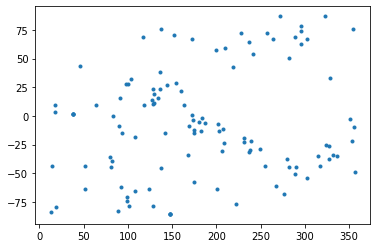

In [23]:
plt.plot(Sample_merge['ra_float'].values.astype(float),Sample_merge['dec_float'].values.astype(float),'.')

In [18]:
Sample_merge['ra_float']

0      179.940000
1      183.310208
2      172.737458
3       98.233542
4       99.791667
          ...    
111    355.971083
112    315.270208
113    160.589167
114    107.718500
115    236.554542
Name: ra_float, Length: 116, dtype: float64

In [6]:
from ..Cheops import CheopsToiList

ImportError: attempted relative import with no known parent package

In [36]:
ser[0].name='this'

In [37]:
ser[0]

mission            tess
ra          07:51:41.91
dec         09:23:06.87
long_gal        211.236
lat_gal         17.6136
               ...     
w2magep            0.02
w3magem           0.017
w3magep           0.017
w4magem           0.088
w4magep           0.088
Name: this, Length: 98, dtype: object

In [27]:
alls.iloc[0][:60]

tcen                                 1350.3126468123182
tdur                                0.13771887703991081
orbit_flag                                         mono
log_lik_mono                         6959.6848851193245
model_success                                     False
log_per                              2.6102074459109437
b                                    0.3589173419587164
log_ror                             -3.2812476866898557
ror                                 0.03758133780818735
r_pl                                 2.8924898457006947
period                               13.601872211952546
vrel                                  14.13787678945024
third_light                                         0.0
depth                             0.0016856096543241986
depth_err                          4.00819271950229e-05
snr                                   42.05410698249824
cdpp                              6.841670398128966e-05
Ntrans                                          

In [9]:
tools.openLightCurve(int(dat['id']),dat['mission'],coor=radec,use_ppt=False)

https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (179.33753056, -16.69767729)>
[] <class 'list'>


TypeError: 'NoneType' object does not support item assignment

In [ ]:
pd.merge(rows)

In [10]:
int(dat['id'])

180220563

In [10]:
dat['dur']

0.1

In [12]:
search.MonoTransitSearch(lc,int(dat['id']),dat['mission'])

167895165 - Searching 87044 positions with 5 durations: 0.155,0.288,0.406,0.519,0.626


({'00': {'llk_trans': -175.86747268089215,
   'llk_sin': -934.7564602450169,
   'llk_poly': -822.1164909706368,
   'BIC_trans': 368.5894561182732,
   'BIC_sin': 1883.1485554216545,
   'BIC_poly': 1659.9332553593947,
   'sin_DeltaBIC': -1514.5590993033813,
   'poly_DeltaBIC': -1291.3437992411216,
   'tcen': 1640.2765376116342,
   'period': nan,
   'period_err': nan,
   'DeltaBIC': -1291.3437992411216,
   'tdur': 0.6261631910872985,
   'depth': 0.0066511475500453535,
   'orbit_flag': 'mono',
   'snr': 7.487339960933181,
   'P_min': 42.227688589102854},
  '01': {'llk_trans': -103.83270476638353,
   'llk_sin': -132.12574885938574,
   'llk_poly': -341.6285740440145,
   'BIC_trans': 224.50968549411363,
   'BIC_sin': 277.8768978552498,
   'BIC_poly': 698.9581271461407,
   'sin_DeltaBIC': -53.36721236113618,
   'poly_DeltaBIC': -474.44844165202704,
   'tcen': 1422.9815009280665,
   'period': nan,
   'period_err': nan,
   'DeltaBIC': -474.44844165202704,
   'tdur': 0.288435974366761,
   'depth'

In [10]:
Rstar[0],Ms,Teff[0]

(1.0577758736623957, 0.9825941136679283, 5803.052894551226)

In [17]:
lc=tools.lcFlatten(lc)

In [18]:
lc

{'bg_flux': array([1183.8984375 , 1174.10107422, 1185.97387695, ..., 1300.76306152,
        1305.73681641, 1312.71728516]),
 'cadence': array(['t2', 't2', 't2', ..., 't2', 't2', 't2'], dtype='<U3'),
 'cent_1': array([1659.40496029, 1659.44891949, 1659.47009763, ..., 1065.450661  ,
        1065.45103122, 1065.44695594]),
 'cent_2': array([ 915.12397891,  915.16881284,  915.19411585, ..., 1407.46839074,
        1407.464274  , 1407.46641899]),
 'flux': array([        nan, -0.00016952, -0.00234884, ..., -0.00093025,
         0.00527835, -0.00268584]),
 'flux_err': array([       nan, 0.00191777, 0.00191942, ..., 0.00246732, 0.00246317,
        0.00246486]),
 'flux_sm_ap': array([nan, nan, nan, ..., nan, nan, nan]),
 'flux_unit': 1.0,
 'flux_xl_ap': array([nan, nan, nan, ..., nan, nan, nan]),
 'mask': array([False,  True,  True, ...,  True,  True,  True]),
 'quality': array([nan, nan, nan, ..., nan, nan, nan]),
 'raw_flux': array([5073.73779297, 5115.11865234, 5115.94873047, ..., 5192.752441

In [58]:
df=

In [59]:
df

,EPIC201346989
llk_trans,-520.7398929474188
llk_sin,-1362.6756189639514
llk_poly,-720.4148009614216
BIC_trans,1055.7575198947286
BIC_sin,2736.4100961029253
...,...
asteroid_bg_stdw,0.03908128678617029
asteroid_bg_stdr,1.0232756002342744
asteroid_snrw,0.00043528301973502244
asteroid_snrr,1.662447587289284e-05


In [83]:
dat=pd.read_csv("/Volumes/LUVOIR/MonoToolsData/EPIC00201346989/EPIC00201346989_CandMonoInfo.csv",index_col=0).T.iloc[0]


In [84]:
dat.name

'EPIC201346989'

ALLWISE|APASS|Bmag|BmagFlag|Dec_orig|EBVflag|GAIA|GAIAmag|HIP|Hmag|ID|Jmag|KIC|Kmag|MH|PARflag|PMflag|POSflag|RA_orig|SDSS|SPFlag|TESSflag|TWOMASS|TWOMflag|TYC|TeffFlag|Tmag|UCAC|Vmag|VmagFlag|contratio|dec|decstr|disposition|dist|epos_dist|eneg_dist|distflag|duplicate_id|e_Bmag|e_Dec|e_Dec_orig|e_GAIAmag|e_Hmag|e_Jmag|e_Kmag|e_MH|e_RA|e_RA_orig|e_Teff|e_Tmag|e_Vmag|e_d|e_ebv|e_gaiabp|e_gaiarp|e_gmag|e_imag|e_logg|e_lum|e_mass|e_plx|e_pmDEC|e_pmRA|e_rad|e_rho|e_rmag|e_umag|e_w1mag|e_w2mag|e_w3mag|e_w4mag|e_zmag|ebv|eclat|eclong|eneg_EBV|eneg_lum|epic_number|epos_EBV|epos_lum|gaiabp|gaiaqflag|gaiarp|gallat|gallong|gmag|imag|k2_campaign_str|k2_kepmag|k2_kepmagerr|k2_kepmagflag|k2_kmag|k2_kmagerr|k2_propid|k2_type|k2_vjmag|k2_vjmagerr|logg|epos_logg|eneg_logg|lum|lumclass|mass|epos_mass|eneg_mass|numcont|objID|objType|plx|pmDEC|pmRA|priority|prox|ra|rad|epos_rad|eneg_rad|raddflag|rastr|rho|epos_rho|eneg_rho|rmag|source|splists|starchareFlag|teff|epos_teff|eneg_teff|tm_name|typeSrc|umag|ve

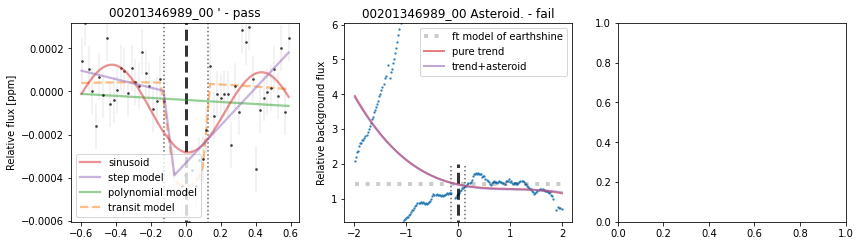

In [85]:
dat=pd.read_csv("/Volumes/LUVOIR/MonoToolsData/EPIC00201346989/EPIC00201346989_CandMonoInfo.csv",index_col=0).T.iloc[0]
dat['mission']='k2'
dat['dur']=float(dat['tdur'])
dat['tcen']=float(dat['tcen'])
dat['id']=dat.name[4:]
file_loc=tools.MonoData_savepath+'/'+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
if not os.path.isdir(file_loc):
    os.system('mkdir '+file_loc)
file_prefix=file_loc+"/"+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
radec=None
#loading Rstar,Tess, logg and rho from csvs:
if not os.path.isfile(file_prefix+'_starpars.csv'):
    try:
        info,_,_=starpars.getStellarInfoFromCsv(int(dat['id']),dat['mission'],radec=radec)
        info.to_csv(file_prefix+'_starpars.csv')
        Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
        Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
        logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
        rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
        FeH=0.0 if 'FeH' not in info else float(info['FeH'])
        if 'mass' in info:
            Ms=float(info['mass'])
        else:
            Ms=rhostar[0]*Rstar[0]**3
    except:
        #STARPARS fails:
        info=pd.Series({'source':None},name=dat['id'])
        Rstar=[1.0]
        Teff=[5800]
        logg=[4.43]
        rhostar=[1.0]
        FeH=0.0
        Ms=1.0
else:
    #print("loading from ",file_prefix+'_starpars.csv')
    info=pd.read_csv(file_prefix+'_starpars.csv', index_col=0, header=0).T.iloc[0]
    print('|'.join(info.index))
    Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
    Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
    logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
    rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
    FeH=0.0 if 'FeH' not in info else float(info['FeH'])
    if 'mass' in info:
        Ms=float(info['mass'])
    else:
        Ms=rhostar[0]*Rstar[0]**3

if 'ra' in info.index and radec is None:
    radec=SkyCoord(float(info['ra'])*u.deg,float(info['dec'])*u.deg)

if not os.path.exists(file_prefix+'_lc.pickle') or dat['mission'].lower()=='corot':
    lc,hdr=tools.openLightCurve(int(dat['id']),dat['mission'],coor=radec,use_ppt=False)
    pickle.dump(lc,open(file_prefix+'_lc.pickle','wb'))
else:
    lc=pickle.load(open(file_prefix+'_lc.pickle','rb'))

if dat['mission'].lower()=='tess' and dat['dur']>0.38 and 't30' in lc['cadence'] and 'bg_flux' in lc and not np.isnan(lc['bg_flux'][lc['cadence']=='t30']).all():
    #Here we have a QLP lightcurve with a long-duration transit. Maybe we should use raw_flux...
    lc['flux'][lc['cadence']=='t30']=lc['raw_flux'][lc['cadence']=='t30']

if np.min(abs(dat['tcen']-lc['time']))<dat['dur']:
    cand={'00':{'tcen':dat['tcen'],'tdur':dat['dur'],'orbit_flag':'mono'}}    
elif np.min(abs((dat['tcen']-(7000-4833))-lc['time']))<dat['dur']:
    cand={'00':{'tcen':dat['tcen']-(7000-4833),'tdur':dat['dur'],'orbit_flag':'mono'}}    
else:
    cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],
                                                  Rs=Rstar[0],Ms=Ms,Teff=Teff[0],plot=False)
if len(cand)>0:
    if cand['00']['tdur'] in [np.nan,0.0]:
        xmask = abs(lc['time']-dat['tcen'])<5 if dat['tcen'] not in [np.nan,0.0,2167.0] else None
        cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                              custom_mask=xmask,plot=False)
        #In the case of a large star, sometimes we niss ultra-short duration transits:
        if Rstar[0]>1.75:
            cand2, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                                  custom_mask=xmask,plot=False)
            if len(cand)==0 or cand2['00']['snr']>cand['00']['snr']:
                cand=cand2

    out, fig = search.VetCand(cand['00'],'00',dat['id'],lc,Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                               file_loc=file_loc,plot=True,vet_do_fit=True)
    floatvars=[var for var in out if type(out[var]) in [int,float,str,np.float64,np.float32]]
    df=pd.Series({var:out[var] for var in floatvars},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
else:
    df=pd.Series({'snr':0,'snr_r':0,
                  'orbit_flag':'mono','flag':'lowSNR'},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
df.to_csv(file_prefix+"_CandMonoInfo.csv")


In [38]:
lc=pickle.load(open("/Volumes/LUVOIR/MonoToolsData/EPIC00201346989/EPIC00201346989_lc.pickle","rb"))

(580.0, 620.0)

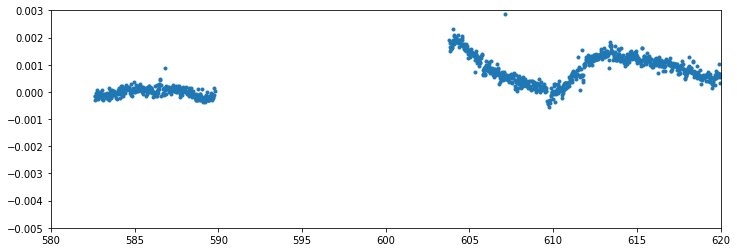

In [44]:
plt.figure(figsize=(12,4))
plt.plot(lc['time'],lc['flux'],'.')
plt.ylim(-0.005,0.003)
plt.xlim(580,620)

(620.0, 652.0)

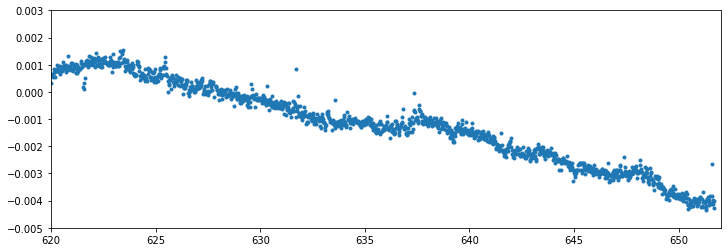

In [43]:
plt.figure(figsize=(12,4))
plt.plot(lc['time'],lc['flux'],'.')
plt.ylim(-0.005,0.003)
plt.xlim(620,652)

(-0.01, 0.01)

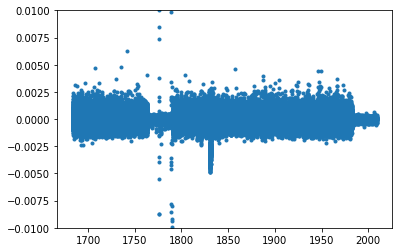

In [89]:
plt.plot(lc['time'],lc['flux'],'.')
plt.ylim(-0.01,0.01)


(-0.002, 0.002)

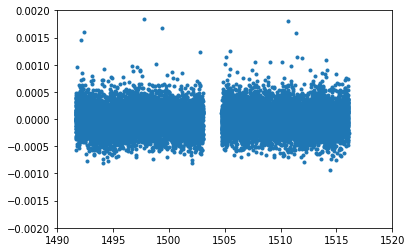

In [36]:
plt.plot(lc['time'],lc['flux'],'.')
plt.xlim(1490,1520)
plt.ylim(-0.002,0.002)

In [90]:
lc=pickle.load(open("/Volumes/LUVOIR/MonoToolsData/TIC00091987762/TIC00091987762_lc.pickle","rb"))

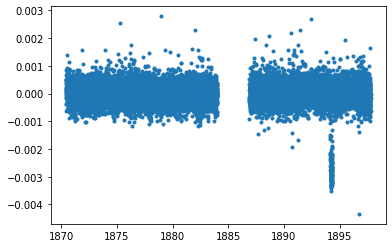

In [91]:
plt.plot(lc['time'],lc['flux'],'.')

In [92]:
pd.read_csv("/Volumes/LUVOIR/MonoToolsData/TIC00091987762/TIC00091987762_CandMonoInfo.csv")

,Unnamed: 0,TIC91987762
0,tcen,1894.253713699096
1,tdur,0.18237363337712006
2,orbit_flag,mono
3,log_lik_mono,7022.603922327079
4,model_success,False
5,log_per,2.3733088416089085
6,b,0.76228256312949
7,log_ror,-2.901854354278278
8,ror,0.054921282056684534
9,r_pl,9.649015364575305


In [ ]:
d

In [87]:
lc,hdr=tools.openLightCurve(int(dat['id']),dat['mission'],coor=radec,use_ppt=False)

https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (105.4908835, -62.88693126)>
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] <class 'list'>
TESS file
18104
1994 points masked in lc of 20076
TESS file
18317
1433 points masked in lc of 19737
TESS file
13452
6269 points masked in lc of 19692
TESS file
15776
2958 points masked in lc of 18684
TESS file
14825
871 points masked in lc of 15678
TESS file
16362
1264 points masked in lc of 17612
TESS file
13420
4347 points masked in lc of 17755
TESS file
15704
2494 points masked in lc of 18187
TESS file
16270
2645 points masked in lc of 18900
TESS file
16797
2755 points masked in lc of 19527
TESS file
19101
1045 points masked in lc of 20119
TESS file
19582
915 points masked in lc of 20479
# Loading QLP lightcurves
167895165 <class 'int'>
610 points masked in lc of 610


In [56]:
int(dat['id'])

167895165

In [73]:
import h5py
f=h5py.File("/Volumes/LUVOIR/MonoToolsData/TIC00167895165/orbit-18_qlplc.h5")

In [86]:
f['LightCurve']['AperturePhotometry']['Aperture_001']['COSMagnitude'][:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [72]:
data_loc="/Volumes/LUVOIR/MonoToolsData/TIC00167895165/"
lcs=[]
lchdrs=[]
for orbit in glob.glob(data_loc+"/*.h5"):
    f=h5py.File(orbit)
    print(orbit)
    if len(lcs)==0 or np.nanmin(abs(np.nanmedian(f['LightCurve']['BJD'])-np.hstack([l['time'] for l in lcs])))>5:
        # This speciic QLP orbit does not have a SPOC lightcurve attached (i.e. no other obs within 5days)
        lcs+=[tools.openFits(f,orbit,mission='tess',use_ppt=True)]
        lchdrs+=[{'source':'qlp'}]


/Volumes/LUVOIR/MonoToolsData/TIC00167895165/orbit-9_qlplc.h5
633
5 points masked in lc of 633
/Volumes/LUVOIR/MonoToolsData/TIC00167895165/orbit-10_qlplc.h5
648
25 points masked in lc of 648
/Volumes/LUVOIR/MonoToolsData/TIC00167895165/orbit-11_qlplc.h5
626
6 points masked in lc of 626
/Volumes/LUVOIR/MonoToolsData/TIC00167895165/orbit-12_qlplc.h5
619
6 points masked in lc of 619
/Volumes/LUVOIR/MonoToolsData/TIC00167895165/orbit-13_qlplc.h5
693
34 points masked in lc of 693
/Volumes/LUVOIR/MonoToolsData/TIC00167895165/orbit-14_qlplc.h5
611
23 points masked in lc of 611
/Volumes/LUVOIR/MonoToolsData/TIC00167895165/orbit-15_qlplc.h5
471
15 points masked in lc of 471
/Volumes/LUVOIR/MonoToolsData/TIC00167895165/orbit-16_qlplc.h5
589
13 points masked in lc of 589
/Volumes/LUVOIR/MonoToolsData/TIC00167895165/orbit-18_qlplc.h5
0


IndexError: index 0 is out of bounds for axis 0 with size 0

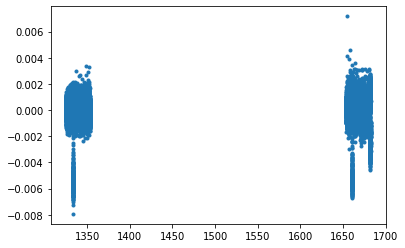

In [17]:
plt.plot(lc['time'],lc['flux'],'.')

In [5]:
int(dat['id']),dat['mission']

(279741379, 'k2')

In [49]:
from MonoTools import starpars
out,_,_=starpars.getStellarInfoFromCsv(125405542,"tess")

Breaking because status = COMPLETE
TESS object


In [41]:
out.iloc[:50]

ALLWISE       J135834.48-230740.4
APASS                    11261937
Bmag                       15.423
BmagFlag                 apassdr9
Dec_orig                 -23.1279
Hmag                        9.538
ID                    1.25406e+08
Jmag                       10.085
Kmag                        9.246
PMflag                       tic7
POSflag                    tmgaia
RA_orig                   209.643
SPFlag                      cdwrf
TESSflag                    cdwrf
TWOMASS          13583455-2307414
TWOMflag      AAA-222-111-000-0-0
Tmag                       11.534
UCAC                   335-071786
Vmag                       13.847
VmagFlag                    cdwrf
dec                      -23.1282
dist                      61.6335
epos_dist                 20.3391
eneg_dist                 20.3391
e_Bmag                      0.043
e_Dec                    0.376911
e_Dec_orig               0.376911
e_Hmag                      0.036
e_Jmag                      0.036
e_Kmag        

In [27]:
out['lum']

0.01597068

In [24]:
out['source']

'TICv8'

1       False
3       False
5       False
7       False
9       False
        ...  
2819    False
2821    False
2823    False
2825    False
2827    False
Name: in, Length: 1414, dtype: bool

In [10]:
[file in c[1]['file'] for file in ['ctoi_monos','AllMonos_martti_tess','Martti_Monos_Tess_South','All_OsbornMarttiK2Monos','lacourse_jacobs_k2_table']]

[False, False, False, False, False]

In [11]:
c[1]['file']

'K2_monos_TSTWG_doc'